In [19]:
# 라이브러리

import pandas as pd ; pd.options.display.float_format = '{:.2f}'.format # 소수 둘째자리까지 표시
import numpy as np
import math

import time
from time import sleep
import random
import datetime
from datetime import datetime, timedelta, datetime
import json

from string import ascii_lowercase

import collections
from dateutil.relativedelta import relativedelta

from powernad.API.Campaign import *
from powernad.API.RelKwdStat import *

from urllib.error import HTTPError
import urllib.request

from bs4 import BeautifulSoup ; import bs4
from selenium import webdriver
import psycopg2
import re

from tqdm.notebook import tqdm

import requests; from urllib.parse import urlparse
import seaborn as sns; sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2) ; sns.set_color_codes()

import matplotlib; import matplotlib.pyplot as plt

import squarify


# 네트워크 시각화용
import warnings
warnings.filterwarnings(action='ignore')

# from matplotlib import font_manager, rc
# from matplotlib import style
# style.use('ggplot')
# %matplotlib inline


# font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf", size=20).get_name()
# rc('font', family=font_name)
# plt.rcParams['axes.unicode_minus'] = False

# 구간날짜 변수 생성

In [20]:
"""
날짜 구간 정보가 들어있는 변수들을 생성합니다.
이 변수들을 활용해 날짜 구간을 기준으로 매일 데이터를 갱신합니다.
...
----------------------------------
today = 현재
today = 오늘자 년월일 문자열
yesterday = 어제 
time_week = 7일 전
time_month = 1개월 전
time_year = 1년 전
time_two_years = 2년 전
time_three_years = 3년 전
"날짜구간 변수명"_index = 날짜구간 인덱스
dt_"날짜구간" = 날짜구간 인덱스를 리스트 형태로 
"""

# 오늘
toda = datetime.now()
today = str(datetime.now().date()) # 


# 1일 전
yesterday = toda - relativedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')
yesterday = str(yesterday)


# 1주
time_week = toda - relativedelta(weeks=1)
time_week = time_week.strftime('%Y-%m-%d')
time_week = str(time_week)
# 최근 1주 리스트
week_index = pd.date_range(start=time_week, end= yesterday)
dt_week = week_index.strftime("%Y-%m-%d").tolist()


# 1개월
time_month = toda - relativedelta(months=1)
time_month = time_month.strftime('%Y-%m-%d')
time_month= str(time_month)
# 최근 1개월 리스트
month_index = pd.date_range(start=time_month, end= yesterday)
dt_month = month_index.strftime("%Y-%m-%d").tolist()


# 1년
time_year = toda - relativedelta(years=1)
time_year = time_year.strftime('%Y-%m-%d')
time_year= str(time_year)
# 최근 1년 리스트
year_index = pd.date_range(start=time_year, end= yesterday)
dt_year = year_index.strftime("%Y-%m-%d").tolist()


# 2년
time_two_years = toda - relativedelta(years=2)
time_two_years = time_two_years.strftime('%Y-%m-%d')
time_two_years = str(time_two_years)
# 최근 2년 리스트
two_years_index = pd.date_range(start=time_two_years, end= yesterday)
dt_two_years = two_years_index.strftime("%Y-%m-%d").tolist()

# 3년
time_three_years = toda - relativedelta(years=3)
time_three_years = time_three_years.strftime('%Y-%m-%d')
time_three_years = str(time_three_years)
# 최근 3년 리스트
three_years_index = pd.date_range(start=time_three_years, end= yesterday)
dt_three_years = three_years_index.strftime("%Y-%m-%d").tolist()

In [21]:
# df_origin
"""
네이버 데이터랩 쇼핑인사이트 기준 일자별 패션의류 카테고리 검색랭킹 500위에 포함된 키워드 정보가 있는 데이터프레임입니다.
데이터 시작일 = 2017-08-01
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""
df_origin = pd.read_csv('C:/project/CODE/keyword/data/fashion/naver_top_500/' + yesterday + '_data.csv', header = None, encoding='utf-8', index_col=0)
df_origin.columns = ['rank', 'keyword', 'year', 'month', 'day', 'ymd']
df_origin = df_origin.sort_values(by=['ymd', 'rank'])
df_origin = df_origin.reset_index(drop=True)
df_origin

,rank,keyword,year,month,day,ymd
0,1,원피스,2017,8,1,2017-08-01
1,2,반팔티,2017,8,1,2017-08-01
2,3,반바지,2017,8,1,2017-08-01
3,4,반티,2017,8,1,2017-08-01
4,5,써스데이아일랜드원피스,2017,8,1,2017-08-01
...,...,...,...,...,...,...
873828,496,글리머,2022,6,12,2022-06-12
873829,497,리본실크잠옷세트,2022,6,12,2022-06-12
873830,498,남자바람막이,2022,6,12,2022-06-12
873831,499,아디다스,2022,6,12,2022-06-12


In [22]:
# df
"""
개별 키워드들의 날짜 정보가 가장 오래된(키워드가 최초 랭크인한 날) 행을 1개만 남기고 나머지 중복값을 모두 삭제한 데이터프레임입니다.
기존에 검색어 랭킹 500위 이내에 없던 키워드가 최초로 랭크된 것은 순간적으로 해당 키워드에 대한 관심도가 증가했다고 볼 수 있습니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df = df_origin.drop_duplicates(['keyword'], keep='first')
df = df.reset_index(drop=True)
df

,rank,keyword,year,month,day,ymd
0,1,원피스,2017,8,1,2017-08-01
1,2,반팔티,2017,8,1,2017-08-01
2,3,반바지,2017,8,1,2017-08-01
3,4,반티,2017,8,1,2017-08-01
4,5,써스데이아일랜드원피스,2017,8,1,2017-08-01
...,...,...,...,...,...,...
8767,368,남성아이스심리스통풍사계절드로즈,2022,6,11,2022-06-11
8768,487,쎄르페,2022,6,11,2022-06-11
8769,325,현재는아름다워옷,2022,6,12,2022-06-12
8770,329,벤티브아이스조거,2022,6,12,2022-06-12


In [23]:
# df_monthly_keywords
"""
최초등장일이 최근 1개월 이내인 키워드들만 보여주는 데이터프레임입니다.
...
rank = 일자별 네이버 데이터랩 검색어 랭킹 (1 ~ 500)
keyword = 검색어 이름
year = 검색어 랭크인한 년도 정보
month = 검색어 랭크인한 월 정보
day = 검색어 랭크인한 일자 정보
ymd = 검색어 랭크인한 당일 년월일 정보
"""

df_monthly_keywords = df.query('ymd == @dt_month')
df_monthly_keywords = df_monthly_keywords.reset_index(drop=True)
df_monthly_keywords 

,rank,keyword,year,month,day,ymd
0,57,올리비아로렌티셔츠,2022,5,13,2022-05-13
1,140,비비안마이핏네모팬티,2022,5,13,2022-05-13
2,245,안나수이원피스,2022,5,13,2022-05-13
3,304,항균여자사각팬티,2022,5,13,2022-05-13
4,404,나이스,2022,5,13,2022-05-13
...,...,...,...,...,...,...
85,368,남성아이스심리스통풍사계절드로즈,2022,6,11,2022-06-11
86,487,쎄르페,2022,6,11,2022-06-11
87,325,현재는아름다워옷,2022,6,12,2022-06-12
88,329,벤티브아이스조거,2022,6,12,2022-06-12


In [24]:
# lis
"""
최초등장일이 최근 1개월 이내인 키워드들이 담긴 리스트를 생성합니다.
"""
lis = list(df_monthly_keywords['keyword'])
len(lis)

90

# 키워드 검색량 조회용 네이버 API

In [25]:
# Naver API 조회용 기본 설정
"""
네이버 광고 API 정보를 조회하기 위한 변수입니다.
...
BASE_URL = 네이버 API 주소
API_KEY = 네이버 검색광고 API 엑세스 라이선스
SECRET_KEY = 네이버 검색광고 API SECRET
CUSTOMER_ID = 네이버 검색광고 API ID
rel = 클라이언트 정보 저장 변수
"""

BASE_URL = 'https://api.naver.com'
API_KEY = '01000000000fcd1ce283f84b5b3f32330368ac6dce35c5a8e3feabf4cfec31ae32b7e9d0e8'
SECRET_KEY = 'AQAAAAAPzRzig/hLWz8yMwNorG3OPks1JGYBp40Ib+rqqydacA=='
CUSTOMER_ID = '2488417'
rel = RelKwdStat(BASE_URL, API_KEY, SECRET_KEY, CUSTOMER_ID)

In [26]:
# search_keyword
def search_keyword(searchword):
    """
    네이버 API 키워드 월간 검색수를 반환해주는 함수입니다.
    ...
    searchword = API 정보를 조회할 키워드명
    """
    
    # kwdDataList = 키워드 검색 정보를 담은 변수입니다.
    kwdDataList = rel.get_rel_kwd_stat_list(siteId=None, biztpId=None, hintKeywords=searchword, event=None, month=None, showDetail='1')

    # kwd_result
    
    '''
    kwdDataList[0].relKeyword = 키워드
    kwdDataList[0].monthlyPcQcCnt = 월간 검색수 (PC)
    kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (Mobile)
    kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt = 월간 검색수 (total)
    '''
    kwd_result = (kwdDataList[0].relKeyword,
                 kwdDataList[0].monthlyPcQcCnt,
                 kwdDataList[0].monthlyMobileQcCnt,
                 kwdDataList[0].monthlyPcQcCnt+kwdDataList[0].monthlyMobileQcCnt)
    
    # kwd_result[3] = 검색한 키워드명과 월간 pc, 모바일, 총 검색수를 반환합니다
    return(kwd_result[3])

# 네이버 데이터랩 (검색어트렌드) 클라이언트 정보
'''
client_id = 네이버 데이터랩 (검색어트렌드) id
client_secret = 네이버 데이터랩 (검색어트렌드) secret
'''
client_id = "IZr05hqQauLB_l9gJEFG"  
client_secret = "cARLdhpO5W"  

In [27]:
# 키워드별 검색량 저장용 자료구조 생성
'''
dictionary_yester = 전일 키워드 검색량 / 딕셔너리
dictionary_now = 오늘자 키워드 검색량  / 딕셔너리
error = 에러 확인 / 리스트
df_total = 일자별 키워드 검색량 / 데이터프레임
'''
dictionary_yester={}
dictionary_now={}
error=[]
df_total = pd.DataFrame(columns=['키워드', '날짜', '수집날짜', '검색량'])


In [28]:
# serach_query
def search_query(list_name):
    """
    위에서 선언한 search_keyword() 함수를 통해 각 키워드의 월간 총 검색량을 추출한 후, 
    날짜별 검색량으로 전환한 데이터프레임을 생성하는 함수입니다.
    ...
    list_name = 조회하고 싶은 키워드 정보가 들어있는 리스트 이름
    """
    
    global df_total
    for i in tqdm(list_name):  
        print(i)
        sleep(1)
        try:
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)


                url = "https://openapi.naver.com/v1/datalab/search"
                body = "{\"startDate\":\""+time_month+"\",\"endDate\":\""+today+"\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\""+i+"\",\"keywords\":[\""+i+"\"]}]}";
                requested = urllib.request.Request(url)
                requested.add_header("X-Naver-Client-Id", client_id)
                requested.add_header("X-Naver-Client-Secret", client_secret)
                requested.add_header("Content-Type", "application/json")
                response = urllib.request.urlopen(requested, data=body.encode("utf-8"))
                rescode = response.getcode()

                if(rescode==200):
                    response_body = response.read()
                    output_data = response_body.decode('utf-8')
                else:
                    print('Error code:'+ rescode)
                    pass

                # result = API 조회 결과값이 들어있는 변수입니다.
                result = json.loads(output_data)

                # date = a['period'] 에서 최근 1개월간의 날짜 값들을 추출한 리스트를 생성합니다.
                date = [a['period'] for a in result['results'][0]['data']]

                # aa = 날짜와 날짜별 검색량을 추출한 데이터프레임을 생성합니다.
                aa = pd.DataFrame({'date':date, 
                              'querycount':[a['ratio'] for a in result['results'][0]['data']],
                              })

                # 일일 데이터 계산 
                sleep(0.5)
                total = aa['querycount'].sum() 
                
                # 30일간 모든 백분율 값을 더한 후 일자별 실제 검색량을 반환합니다.
                '''
                total = 날짜별 모든 백분율 검색량을 더한 값
                float(a) = 월간 총 검색량 실수화
                x = 각 일자별 검색량
                '''
                aa['검색량'] = aa['querycount'].apply(lambda x :((x / total)*float(a)))


            else : 
                pass

        except (TypeError, IndexError,KeyError,ValueError):
            print(" 타입 or 인덱스 에러,Value 에러:",i)
            error.append(i)
            pass


        except HTTPError:
            print('http 에러:', i )
            error.append(i)
            pass

            #여기부터 새로 코딩
        try: 
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        


                date = pd.DataFrame(data=dt_month, columns=['날짜'])

                spred = pd.merge(date,aa,left_on='날짜',right_on='date',how='outer')
                spred.drop(['date'],inplace=True, axis=1)

                spred.replace(np.nan,0,inplace=True)


                a=[] 

                for j in range(len(spred)) : 
                    a.append(today)


                spred['수집날짜'] = a
                spred['키워드'] = i
                spred = spred[['키워드', '날짜','수집날짜', '검색량']]

                if i in dictionary_yester:

                    pass

                else : 
                    dictionary_yester[i]=[]



                dictionary_now[i]=spred
                df_total = pd.concat([df_total, spred])

            else:
                pass

        except (TypeError, IndexError,KeyError,ValueError):

            pass

        sleep(0.5)
        try :
            if type(search_keyword(i)) !=str : 
                searchword = i.replace(" ","")
                a = search_keyword(searchword)        

                if dictionary_yester[i]==[]:
                    dictionary_yester[i] = dictionary_now[i]

                else : 
                    pass 
            else:
                pass


        except (TypeError, IndexError,KeyError):
              pass


        except ValueError:


                yester_df= dictionary_yester[i]
                today_df = dictionary_now[i]


                yester_df.set_index('날짜',inplace=True)

                today_df.set_index('날짜',inplace=True)

                yester_df.update(today_df)


                tmpt = today_df.iloc[-1,:]

                yester_df = yester_df.append(tmpt)

                yester_df.reset_index(inplace=True)
                today_df.reset_index(inplace=True)


                dictionary_yester[i] = yester_df


        except :
            print('API 에러',i)
            error.append(i)



        sleep(3)

    df_total['검색량'] = df_total['검색량'].astype(int)
    
    df_total.to_csv('C:/project/CODE/keyword/data/fashion/query/' + yesterday + '_month_fashion_query_by_date.csv', encoding='UTF-8')
    
    return(df_total)

In [29]:
search_query(lis)

  0%|          | 0/90 [00:00<?, ?it/s]

올리비아로렌티셔츠
비비안마이핏네모팬티
안나수이원피스
항균여자사각팬티
나이스
행텐10320-150-404-51
리린
법복
모르간썸머원피스
한지민가디건
스프리스기능성바람막이
쿨스판골지여자밴딩와이드바지
 타입 or 인덱스 에러,Value 에러: 쿨스판골지여자밴딩와이드바지
에바큐브
여성정장하객룩
나이키더블스우시후드집업
마틴발썸머울카라니트
여성여름정장
유니클로마르니
딜레탕티즘
셀린느티셔츠
닉스조거팬츠
클로앤차이가디건형니트
디키즈874여자
반팔청자켓
레이지카키하프조거팬츠
테이퍼드세미와이드청바지
남성린넨체크셔츠
 타입 or 인덱스 에러,Value 에러: 남성린넨체크셔츠
트위드반팔
남자무지트임브이넥
 타입 or 인덱스 에러,Value 에러: 남자무지트임브이넥
마드제이
테이핑브라
데일리셔링청롱원피스
 타입 or 인덱스 에러,Value 에러: 데일리셔링청롱원피스
여성반팔가디건
유에르
지오다노101221
커클랜드티셔츠
헬스오버핏반팔티셔츠
 타입 or 인덱스 에러,Value 에러: 헬스오버핏반팔티셔츠
테니스원피스
노가다망사작업조끼
 타입 or 인덱스 에러,Value 에러: 노가다망사작업조끼
텐셀배기진
 타입 or 인덱스 에러,Value 에러: 텐셀배기진
러브이즈트루
가니송
신혼부부
리스트바지
여성롱원피스
폴로반팔셔츠
리바이스쿨진여성
엉뽕
쿨스판스판팬츠
비비안컴포트브라팬티
맥스튜어트뉴욕데님
질염예방여성면팬티
 타입 or 인덱스 에러,Value 에러: 질염예방여성면팬티
트임밴딩롱스커트
마리나요팅티셔츠
바스락스커트
달고나라인린넨원피스
 타입 or 인덱스 에러,Value 에러: 달고나라인린넨원피스
비뮤즈맨션
Http status: 429
failed to request
김나영실리콘니플패치니플패드
 타입 or 인덱스 에러,Value 에러: 김나영실리콘니플패치니플패드
다다있어민소매
 타입 or 인덱스 에러,Value 에러: 다다있어민소매
리더잭텐셀풀스트링팬츠
Http status: 429
failed to request
올앤선드리원피스
Http status: 429
failed to requ

,키워드,날짜,수집날짜,검색량
0,올리비아로렌티셔츠,2022-05-13,2022-06-13,102
1,올리비아로렌티셔츠,2022-05-14,2022-06-13,116
2,올리비아로렌티셔츠,2022-05-15,2022-06-13,104
3,올리비아로렌티셔츠,2022-05-16,2022-06-13,105
4,올리비아로렌티셔츠,2022-05-17,2022-06-13,130
...,...,...,...,...
26,현재는아름다워옷,2022-06-08,2022-06-13,260
27,현재는아름다워옷,2022-06-09,2022-06-13,208
28,현재는아름다워옷,2022-06-10,2022-06-13,293
29,현재는아름다워옷,2022-06-11,2022-06-13,1924


In [30]:
# df_query
"""
네이버 패션의류 탑 500 에 신규진입한 키워드의 최근 1개월 동안의 일자별 검색량이 있는 데이터프레임입니다.
"""
df_query = df_total
df_query = df_query[['키워드', '날짜', '수집날짜', '검색량']]
df_query = df_query.rename(columns={'키워드':'keyword', '날짜':'ymd', '수집날짜':'search_date', '검색량': 'query'})
df_query['query'] = df_query['query'].astype(int)
df_query

,keyword,ymd,search_date,query
0,올리비아로렌티셔츠,2022-05-13,2022-06-13,102
1,올리비아로렌티셔츠,2022-05-14,2022-06-13,116
2,올리비아로렌티셔츠,2022-05-15,2022-06-13,104
3,올리비아로렌티셔츠,2022-05-16,2022-06-13,105
4,올리비아로렌티셔츠,2022-05-17,2022-06-13,130
...,...,...,...,...
26,현재는아름다워옷,2022-06-08,2022-06-13,260
27,현재는아름다워옷,2022-06-09,2022-06-13,208
28,현재는아름다워옷,2022-06-10,2022-06-13,293
29,현재는아름다워옷,2022-06-11,2022-06-13,1924


In [31]:
# df_query_sum
"""
신규키워드들의 최근 1개월 누적 검색량이 있는 데이터프레임입니다.
"""
df_query_sum = df_query[['keyword', 'query']].groupby('keyword').sum()
df_query_sum = df_query_sum.rename(columns = {'query':'query_month'})
df_query_sum.sort_values('query_month', ascending=False)

,query_month
keyword,
리린,392384
나이스,181583
유니클로마르니,133081
마드제이,29996
현재는아름다워옷,29255
디키즈874여자,25914
폴로반팔셔츠,21929
셀린느티셔츠,21623
여성여름정장,19853


In [32]:
# df_query_m
"""
최근 1개월 이내에 키워드 검색 탑 500에 등장한 키워드들의 검색량을 보여주는 데이터프레임입니다.
...
query = 신규 키워드 랭크 진입 당일 검색량
query_month = 신규 키워드의 최근 1개월 누적 검색량
"""

df_query_m = pd.merge(df_monthly_keywords, df_query, on='keyword')
df_query_m = pd.merge(df_query_m, df_query_sum, on = 'keyword')
df_query_m = df_query_m[df_query_m['ymd_x'] == df_query_m['ymd_y']]
df_query_m = df_query_m.drop(['ymd_y'], axis=1).sort_values(['ymd_x', 'rank'])
df_query_m.rename(columns = {'ymd_x':'ymd'},inplace=True)
df_query_m.reset_index(inplace=True, drop=True)

df_query_m

,rank,keyword,year,month,day,ymd,search_date,query,query_month
0,57,올리비아로렌티셔츠,2022,5,13,2022-05-13,2022-06-13,102,4183
1,140,비비안마이핏네모팬티,2022,5,13,2022-05-13,2022-06-13,564,1041
2,245,안나수이원피스,2022,5,13,2022-05-13,2022-06-13,655,15025
3,404,나이스,2022,5,13,2022-05-13,2022-06-13,8945,181583
4,198,행텐10320-150-404-51,2022,5,14,2022-05-14,2022-06-13,309,1747
5,293,리린,2022,5,14,2022-05-14,2022-06-13,13002,392384
6,465,법복,2022,5,14,2022-05-14,2022-06-13,942,9192
7,287,모르간썸머원피스,2022,5,15,2022-05-15,2022-06-13,1038,3937
8,339,한지민가디건,2022,5,15,2022-05-15,2022-06-13,1611,5946
9,492,스프리스기능성바람막이,2022,5,15,2022-05-15,2022-06-13,569,1400


In [52]:
# df_m
"""
최근 1개월 이내 키워드 검색 탑 500 에 등장한 키워드 정보가 담겨있는 데이터프레임입니다.
*********************** 최종적으로 스트림릿에 추가해야하는 데이터프레임 *************************
"""
df_m = pd.DataFrame({'등장일자':df_query_m['ymd'], '랭킹':df_query_m['rank'], '키워드':df_query_m['keyword'], '일간검색량':df_query_m['query'], '월간검색량':df_query_m['query_month']})
df_m = df_m.sort_values('등장일자', ascending=False)
df_m.to_csv('C:/project/CODE/keyword/data/fashion/output/' + yesterday + '_trendy_fashion_keywords.csv', encoding='UTF-8')
df_m.head(50)


,등장일자,랭킹,키워드,일간검색량,월간검색량
59,2022-06-12,325,현재는아름다워옷,3909,29255
58,2022-06-11,487,쎄르페,7,673
57,2022-06-11,153,드로우즈팬티,20,234
56,2022-06-10,468,비비안컴포트브라,399,1025
55,2022-06-10,429,아우터,125,5705
54,2022-06-10,361,신영와코루슬림업,1319,2903
53,2022-06-07,406,컬럼비아유니버시티,23,845
52,2022-06-07,256,쌍방울하나만,1858,3386
51,2022-06-06,457,누모브라렛,10,95
50,2022-06-06,424,코닥반팔티,1040,17476


In [54]:
df_m_list = list(df_m['키워드'])

In [55]:
# keyword_grouping

splitted_list = [['잠옷']] # splitted_list = 기준 키워드
def keyword_grouping(list_name):
    """
    키워드의 장기간 검색량을 일자별로 수집하는 함수입니다.
    네이버 API는 한번에 5개까지만 키워드를 조회할 수 있는데, 한 번에 5개 이상의 키워드 검색량 정보를 조회합니다.
    단, 네이버 API 를 통해 최근 1개월보다 이전의 검색량을 조회할 경우, 
    검색된 키워드의 검색량이 아니라 조회한 키워드 중 검색량이 가장 많았던 시점을 기준으로 0 ~ 100 사이의 백분율 정보를 제공합니다.
    각 키워드의 실제 검색량이 달라도 같은 100으로 집계되는 경우를 방지하기 위해 5개의 그룹에 항상 포함되는 기준 키워드를 설정했습니다.
    ex)
    ['잠옷', 'A', 'B', 'C', 'D']
    ['잠옷', 'E', 'F', 'G', 'H']
    ...
    list_name = 조회할 키워드가 들어있는 리스트명
    """

    # 키워드가 5개씩 순차적으로 들어있는 2차원 리스트 생성 반복문
    # 마지막 리스트가 5개로 떨어지지 않을 경우 '더미' 를 채워서 5개를 완성합니다.
    for i in range(0, len(list_name), 4):
        y = []
        if i <= len(list_name) - 4:
            y = [list_name[i], list_name[i+1], list_name[i+2], list_name[i+3]]
            splitted_list.append(y)
        elif i == len(list_name) - 3:
            y = [list_name[i], list_name[i+1], list_name[i+2], '더미']
            splitted_list.append(y)
        elif i == len(list_name) - 2:
            y = [list_name[i], list_name[i+1], '더미', '더미']
            splitted_list.append(y)
        else:
            y = [list_name[i], '더미', '더미', '더미']
            splitted_list.append(y)  

    i = 1
    
    return splitted_list

In [56]:
keyword_grouping(df_m_list)

[['잠옷'],
 ['현재는아름다워옷', '쎄르페', '드로우즈팬티', '비비안컴포트브라'],
 ['아우터', '신영와코루슬림업', '컬럼비아유니버시티', '쌍방울하나만'],
 ['누모브라렛', '코닥반팔티', '올리브그린썸머하이웨이팬츠', '안지크원피스'],
 ['세루티니트', '리더잭텐셀풀스트링팬츠', '올앤선드리원피스', '비뮤즈맨션'],
 ['바스락스커트', '마리나요팅티셔츠', '맥스튜어트뉴욕데님', '비비안컴포트브라팬티'],
 ['엉뽕', '리바이스쿨진여성', '폴로반팔셔츠', '여성롱원피스'],
 ['리스트바지', '신혼부부', '가니송', '러브이즈트루'],
 ['테니스원피스', '커클랜드티셔츠', '유에르', '여성반팔가디건'],
 ['테이핑브라', '지오다노101221', '마드제이', '트위드반팔'],
 ['테이퍼드세미와이드청바지', '레이지카키하프조거팬츠', '반팔청자켓', '디키즈874여자'],
 ['셀린느티셔츠', '클로앤차이가디건형니트', '닉스조거팬츠', '딜레탕티즘'],
 ['유니클로마르니', '여성여름정장', '마틴발썸머울카라니트', '나이키더블스우시후드집업'],
 ['여성정장하객룩', '에바큐브', '스프리스기능성바람막이', '한지민가디건'],
 ['모르간썸머원피스', '법복', '리린', '행텐10320-150-404-51'],
 ['안나수이원피스', '비비안마이핏네모팬티', '나이스', '올리비아로렌티셔츠']]

In [36]:
# datalab_api
def datalab_api(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]},
            {"groupName":str(keywords[2]),"keywords":[str(keywords[2])]},
            {"groupName":str(keywords[3]),"keywords":[str(keywords[3])]},
            {"groupName":str(keywords[4]),"keywords":[str(keywords[4])]},
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])
    df3 = pd.DataFrame(json_obj['results'][2]['data'])
    df4 = pd.DataFrame(json_obj['results'][3]['data'])
    df5 = pd.DataFrame(json_obj['results'][4]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2,df3,df4,df5]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)
    df3 = df2.merge(df3, how='outer', on='기간').fillna(0)
    df4 = df3.merge(df4, how='outer', on='기간').fillna(0)
    df5 = df4.merge(df5, how='outer', on='기간').fillna(0)

    return df5


In [37]:
# df_api
"""
기준 키워드(잠옷)의 검색량 최소값과 최대값을 구해서 상대치를 갱신하는 정규화입니다.
"""
df_api = datalab_api(splitted_list[0] + splitted_list[1])
a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
print('기준 키워드(잠옷) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"))

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(잠옷) 검색량 최소값: 14.11478, 최대값100.00000


In [57]:
# datalab_api_keylist
def datalab_api_keylist(list_name):
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    ...
    list_name = 기준 키워드와 검색량을 조회할 키워드들이 들어있는 2차원 리스트
    """
    
    # df_api
    # 기준 키워드(잠옷)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api(list_name[0]+list_name[1])
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    print('기준 키워드(잠옷) 검색량 최소값: ' + format(a, ".5f") + ', 최대값' + format(b, ".5f"), '\n')
    
    i = 2
    while i < len(list_name):
        try:
            df1 = datalab_api(list_name[0]+list_name[i])
            x, y = df1.iloc[:,1].min(), df1.iloc[:,1].max()    
            # df1 = 기준 키워드 검색량의 최소-최대 정규화

            df1.iloc[:,2] = (df1.iloc[:,2] -x) / (y - x) * (b - a) + a
            df1.iloc[:,3] = (df1.iloc[:,3] -x) / (y - x) * (b - a) + a
            df1.iloc[:,4] = (df1.iloc[:,4] -x) / (y - x) * (b - a) + a
            df1.iloc[:,5] = (df1.iloc[:,5] -x) / (y - x) * (b - a) + a
            df1 = df1.drop(columns=['기간', '잠옷'])
            df_api = pd.concat([df_api, df1], axis=1)

            
            i+=1
        
            time.sleep( random.uniform(2,4) )
        
        except IndexError:
            pass
        
        print('작업 진행률: ' + format(i / len(splitted_list), ".2f"))

    # 더미 키워드 삭제 및 저장
    df_api = df_api[df_api.columns.drop(list(df_api.filter(regex='더미')))]
    df_api.to_csv('C:/project/CODE/keyword/data/fashion/query/' + yesterday + '_three_years_fashion_query.csv', encoding='UTF-8')

    # 
    return df_api

In [59]:
datalab_api_keylist(splitted_list)

  0%|          | 0/5 [00:00<?, ?it/s]

기준 키워드(잠옷) 검색량 최소값: 14.11478, 최대값100.00000 



  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.19


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.25


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.31


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.38


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.44


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.50


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.56


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.62


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.69


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.75


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.81


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.88


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 0.94


  0%|          | 0/5 [00:00<?, ?it/s]

작업 진행률: 1.00


,기간,잠옷,현재는아름다워옷,쎄르페,드로우즈팬티,비비안컴포트브라,아우터,신영와코루슬림업,컬럼비아유니버시티,쌍방울하나만,...,스프리스기능성바람막이,한지민가디건,모르간썸머원피스,법복,리린,행텐10320-150-404-51,안나수이원피스,비비안마이핏네모팬티,나이스,올리비아로렌티셔츠
0,2019-06-13,16.32,0.00,0.00,0.00,0.00,2.27,0.00,0.00,0.00,...,0.00,0.07,0.00,1.11,73.60,0.00,0.07,0.00,50.36,0.45
1,2019-06-14,14.93,0.00,0.00,0.00,0.00,2.21,0.00,0.00,0.00,...,0.00,0.11,0.00,1.02,65.56,0.00,0.08,0.00,53.95,0.34
2,2019-06-15,14.59,0.00,0.00,0.00,0.00,2.40,0.00,0.00,0.00,...,0.00,0.00,0.00,0.78,57.84,0.00,0.03,0.00,32.50,0.54
3,2019-06-16,18.80,0.00,0.00,0.00,0.00,2.35,0.00,0.00,0.00,...,0.00,0.06,0.00,0.79,58.04,0.00,0.06,0.00,31.20,0.35
4,2019-06-17,18.46,0.00,0.00,0.00,0.00,2.31,0.00,0.00,0.00,...,0.00,0.00,0.00,1.18,74.11,0.00,0.10,0.00,66.09,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2022-06-08,29.44,1.82,0.06,0.00,0.00,1.13,0.08,0.07,7.67,...,0.14,0.26,0.49,1.45,93.33,0.22,4.49,0.00,37.65,0.82
1092,2022-06-09,26.02,1.46,0.09,0.00,0.00,1.15,0.10,0.06,0.77,...,0.11,0.13,0.35,1.30,92.96,0.22,2.21,0.00,35.35,0.90
1093,2022-06-10,24.43,2.06,0.09,0.03,2.61,0.86,8.40,0.12,0.51,...,0.08,0.19,0.41,1.16,82.58,0.24,4.04,0.06,35.74,1.17
1094,2022-06-11,27.33,13.49,0.05,0.08,0.16,1.09,1.02,0.06,0.63,...,0.08,0.20,0.10,0.90,69.76,0.15,7.51,0.00,24.29,1.12


# 키워드 검색량 시각화

In [60]:
# df_vis
"""
최근 1개월 이내 탑 500 키워드에 진입한 키워드들의 일자별 검색량 정보가 있는 데이터프레임입니다.
시작날짜 = 2019-06(3년전)
종료날짜 = 1일전
데이터프레임의 '기간' 컬럼을 datetime 자료형으로 변경한 후 년, 월, 일 컬럼을 추가합니다.
"""
df_vis = pd.read_csv('C:/project/CODE/keyword/data/fashion/query/'+ yesterday + '_three_years_fashion_query.csv', encoding='UTF-8', index_col=0)
df_vis['기간']= pd.to_datetime(df_vis['기간'])
df_vis['year'] = df_vis['기간'].dt.year
df_vis['month'] = df_vis['기간'].dt.month
df_vis['date'] = df_vis['기간'].dt.date
df_vis = df_vis.set_index('기간') # 년월일을 인덱스로 지정
df_vis

,잠옷,현재는아름다워옷,쎄르페,드로우즈팬티,비비안컴포트브라,아우터,신영와코루슬림업,컬럼비아유니버시티,쌍방울하나만,누모브라렛,...,법복,리린,행텐10320-150-404-51,안나수이원피스,비비안마이핏네모팬티,나이스,올리비아로렌티셔츠,year,month,date
기간,,,,,,,,,,,,,,,,,,,,,
2019-06-13,16.32,0.00,0.00,0.00,0.00,2.27,0.00,0.00,0.00,0.00,...,1.11,73.60,0.00,0.07,0.00,50.36,0.45,2019,6,2019-06-13
2019-06-14,14.93,0.00,0.00,0.00,0.00,2.21,0.00,0.00,0.00,0.00,...,1.02,65.56,0.00,0.08,0.00,53.95,0.34,2019,6,2019-06-14
2019-06-15,14.59,0.00,0.00,0.00,0.00,2.40,0.00,0.00,0.00,0.00,...,0.78,57.84,0.00,0.03,0.00,32.50,0.54,2019,6,2019-06-15
2019-06-16,18.80,0.00,0.00,0.00,0.00,2.35,0.00,0.00,0.00,0.00,...,0.79,58.04,0.00,0.06,0.00,31.20,0.35,2019,6,2019-06-16
2019-06-17,18.46,0.00,0.00,0.00,0.00,2.31,0.00,0.00,0.00,0.00,...,1.18,74.11,0.00,0.10,0.00,66.09,0.28,2019,6,2019-06-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-08,29.44,1.82,0.06,0.00,0.00,1.13,0.08,0.07,7.67,0.06,...,1.45,93.33,0.22,4.49,0.00,37.65,0.82,2022,6,2022-06-08
2022-06-09,26.02,1.46,0.09,0.00,0.00,1.15,0.10,0.06,0.77,0.06,...,1.30,92.96,0.22,2.21,0.00,35.35,0.90,2022,6,2022-06-09
2022-06-10,24.43,2.06,0.09,0.03,2.61,0.86,8.40,0.12,0.51,0.05,...,1.16,82.58,0.24,4.04,0.06,35.74,1.17,2022,6,2022-06-10


In [61]:
# 키워드를 연도별로 그룹화해서 각각의 연평균 검색량을 조회
df_vis.groupby(df_vis.index.year).mean()

,잠옷,현재는아름다워옷,쎄르페,드로우즈팬티,비비안컴포트브라,아우터,신영와코루슬림업,컬럼비아유니버시티,쌍방울하나만,누모브라렛,...,모르간썸머원피스,법복,리린,행텐10320-150-404-51,안나수이원피스,비비안마이핏네모팬티,나이스,올리비아로렌티셔츠,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,26.03,0.00,0.00,0.00,0.00,4.31,0.00,0.00,0.00,0.00,...,0.00,0.96,62.72,0.00,0.03,0.00,54.01,0.37,2019.00,9.18
2020,47.14,0.00,0.03,0.00,0.00,3.84,0.00,0.00,0.00,0.00,...,0.05,1.01,63.26,0.00,0.13,0.00,108.30,0.52,2020.00,6.51
2021,37.99,0.00,0.04,0.52,0.00,3.45,0.00,0.03,0.02,0.00,...,0.05,0.93,72.86,0.00,0.18,0.00,121.42,0.61,2021.00,6.53
2022,33.16,1.57,0.06,0.02,0.04,2.86,0.28,0.20,0.14,0.00,...,0.26,1.26,80.68,0.08,0.88,0.13,84.46,0.76,2022.00,3.23


In [62]:
# 키워드를 연도별로 그룹화해서 각각의 전년대비 평균 검색량 변화율을 조회
df_vis.groupby(df_vis.index.year).mean().pct_change()

,잠옷,현재는아름다워옷,쎄르페,드로우즈팬티,비비안컴포트브라,아우터,신영와코루슬림업,컬럼비아유니버시티,쌍방울하나만,누모브라렛,...,모르간썸머원피스,법복,리린,행텐10320-150-404-51,안나수이원피스,비비안마이핏네모팬티,나이스,올리비아로렌티셔츠,year,month
기간,,,,,,,,,,,,,,,,,,,,,
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020,0.81,NaN,6.00,0.39,NaN,-0.11,NaN,inf,NaN,NaN,...,10892.76,0.05,0.01,0.00,3.55,0.00,1.01,0.42,0.00,-0.29
2021,-0.19,NaN,0.57,108.82,NaN,-0.10,NaN,343.55,inf,NaN,...,-0.09,-0.08,0.15,316.07,0.37,0.00,0.12,0.18,0.00,0.00
2022,-0.13,inf,0.47,-0.96,inf,-0.17,inf,5.08,7.72,inf,...,4.57,0.36,0.11,52.66,3.76,2679.01,-0.30,0.23,0.00,-0.50


In [63]:
# df_ym
# 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
df_vis['year'] = df_vis.index.year; df_vis['month'] = df_vis.index.month
df_ym = df_vis.groupby([df_vis.index.year, df_vis.index.month]).mean()
df_ym

잠옷  현재는아름다워옷  쎄르페  드로우즈팬티  비비안컴포트브라  아우터  신영와코루슬림업  컬럼비아유니버시티  \
기간   기간                                                                    
2019 6  16.93      0.00 0.00    0.00      0.00 2.23      0.00       0.00   
     7  18.26      0.00 0.00    0.01      0.00 1.91      0.00       0.00   
     8  18.09      0.00 0.00    0.00      0.00 2.36      0.00       0.00   
     9  22.80      0.00 0.00    0.00      0.00 4.24      0.00       0.00   
     10 30.69      0.00 0.01    0.01      0.00 6.73      0.00       0.00   
     11 33.77      0.00 0.01    0.00      0.00 7.70      0.00       0.00   
     12 38.00      0.00 0.01    0.00      0.00 4.20      0.00       0.00   
2020 1  29.98      0.00 0.01    0.00      0.00 3.83      0.00       0.00   
     2  36.90      0.00 0.00    0.01      0.00 4.73      0.00       0.00   
     3  57.02      0.00 0.00    0.00      0.00 4.90      0.00       0.00   
     4  54.79      0.00 0.01    0.00      0.00 3.77      0.00       0.00   
     5  48.91      0.00 0.02    0.01      0.00 2.17      0.00       0.00   
     6  38.33      0.00 0.02    0.01      0.00 1.34      0.00       0.00   
     7  31.74      0.00 0.03    0.00      0.00 1.32      0.00       0.00   
     8  34.98      0.00 0.03    0.01      0.00 1.71      0.00       0.00   
     9  52.13      0.00 0.09    0.00      0.00 4.00      0.00       0.00   
     10 59.20      0.00 0.04    0.00      0.00 7.74      0.00       0.00   
     11 49.37      0.00 0.03    0.01      0.00 6.98      0.00       0.00   
     12 71.81      0.00 0.02    0.00      0.00 3.65      0.00       0.00   
2021 1  51.79      0.00 0.01    0.01      0.00 3.06      0.00       0.00   
     2  40.50      0.00 0.01    0.02      0.00 3.93      0.00       0.00   
     3  37.53      0.00 0.02    0.17      0.00 5.03      0.00       0.00   
     4  36.04      0.00 0.03    0.46      0.00 3.28      0.00       0.00   
     5  34.28      0.00 0.08    1.72      0.00 2.04      0.00       0.00   
     6  30.51      0.00 0.06    1.26      0.00 1.18      0.00       0.00   
     7  31.56      0.00 0.05    1.35      0.00 1.07      0.00       0.00   
     8  28.40      0.00 0.04    1.12      0.00 2.18      0.00       0.00   
     9  33.71      0.00 0.03    0.01      0.00 3.51      0.00       0.06   
     10 46.02      0.00 0.05    0.00      0.00 6.41      0.00       0.08   
     11 41.98      0.00 0.05    0.00      0.00 6.23      0.00       0.11   
     12 43.47      0.00 0.06    0.00      0.00 3.56      0.00       0.14   
2022 1  34.42      0.00 0.03    0.01      0.00 2.94      0.00       0.25   
     2  36.94      0.00 0.03    0.01      0.00 3.62      0.00       0.19   
     3  34.38      0.00 0.04    0.01      0.00 4.41      0.20       0.18   
     4  33.20      0.49 0.06    0.02      0.00 2.59      0.50       0.17   
     5  28.92      4.36 0.14    0.03      0.11 1.51      0.44       0.24   
     6  28.76      8.80 0.07    0.02      0.27 1.10      0.92       0.12   

         쌍방울하나만  누모브라렛  ...  모르간썸머원피스   법복    리린  행텐10320-150-404-51  안나수이원피스  \
기간   기간                 ...                                                     
2019 6     0.00   0.00  ...      0.00 0.91 66.06                0.00     0.06   
     7     0.00   0.00  ...      0.00 1.01 61.58                0.00     0.05   
     8     0.00   0.00  ...      0.00 0.95 51.14                0.00     0.04   
     9     0.00   0.00  ...      0.00 1.09 59.60                0.00     0.02   
     10    0.00   0.00  ...      0.00 1.10 67.38                0.00     0.02   
     11    0.00   0.00  ...      0.00 0.85 72.03                0.00     0.02   
     12    0.00   0.00  ...      0.00 0.80 62.80                0.00     0.02   
2020 1     0.00   0.00  ...      0.00 0.96 51.55                0.00     0.02   
     2     0.00   0.00  ...      0.00 0.95 59.25                0.00     0.06   
     3     0.00   0.00  ...      0.00 0.72 65.45                0.00     0.08   
     4     0.00   0.00  ...      0.18 0.98 64.44                0.00     0

In [64]:
# 아래 시각화와 같이 볼 신규 키워드 데이터프레임 호출
df_m.sort_values('월간검색량', ascending=False).head(50)

,등장일자,랭킹,키워드,일간검색량,월간검색량
5,2022-05-14,293,리린,13002,392384
3,2022-05-13,404,나이스,8945,181583
15,2022-05-20,73,유니클로마르니,38220,133081
25,2022-05-24,457,마드제이,3084,29996
59,2022-06-12,325,현재는아름다워옷,3909,29255
20,2022-05-22,210,디키즈874여자,2626,25914
37,2022-05-28,488,폴로반팔셔츠,771,21929
17,2022-05-21,368,셀린느티셔츠,1426,21623
14,2022-05-19,398,여성여름정장,673,19853
32,2022-05-27,443,러브이즈트루,754,18534


In [65]:
# create_barplot
def create_barplot():
    """
    신규 랭킹 키워드 랭크 진입 당일 검색량을 시각화하는 함수입니다.
    ...
    key_col = x 축 지정 / df_m 에서 키워드 명이 있는 컬럼명 입력 (ex. '키워드')
    val_col = y 축 지정 / df_m 에서 키워드 검색량이 있는 컬럼명 입력 (ex. '일간검색량', '월간검색량')
    """
    val_col = input("일간검색량, 월간검색량 중 조회하고 싶은 정보를 입력하세요. ")
    sns.set(style='darkgrid', font='NanumGothic', font_scale=1.4)
    df1 = pd.DataFrame(df_m[['키워드', val_col]].sort_values(by=val_col, ascending=False))
    df2 = df1.head(30) # head or tail
    f, ax = plt.subplots(figsize=(20, 20)); plt.xticks(rotation=90) ; plt.title("신규 키워드 "+ val_col)
    plot = ax.bar(df2['키워드'], df2[val_col], color=sns.color_palette("rocket", len(df2.index)))
    for rect in plot:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, '%d' %int(height), ha='center', va='bottom')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_신규_키워드_' + val_col + '_바차트.png', bbox_inches='tight')


일간검색량, 월간검색량 중 조회하고 싶은 정보를 입력하세요. 월간검색량


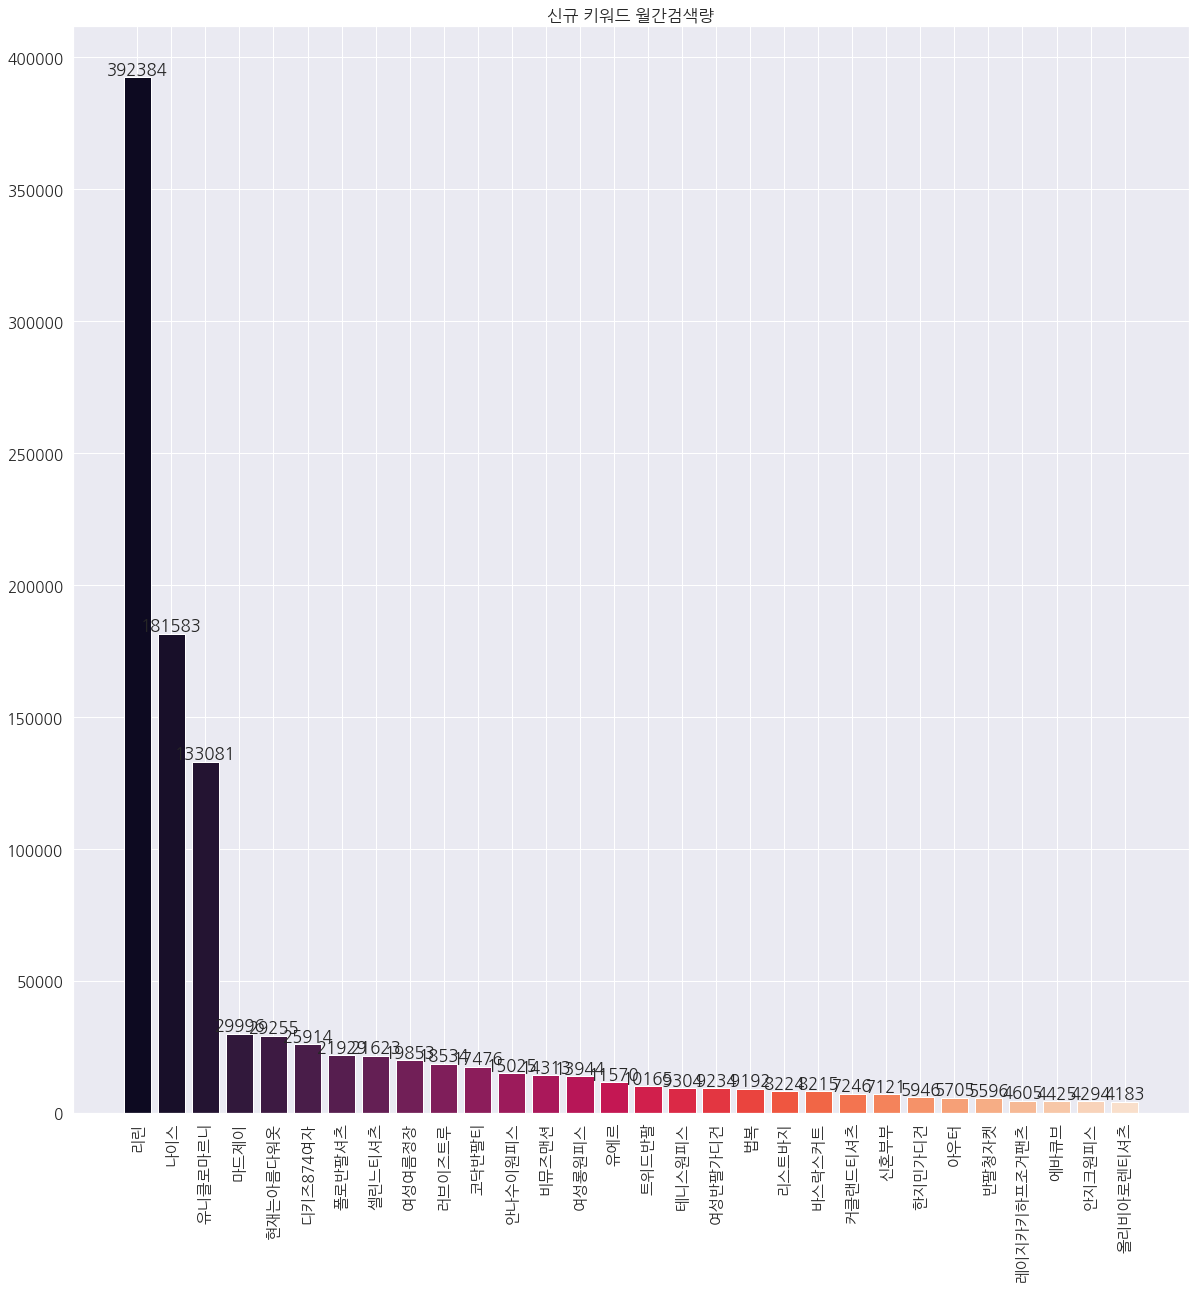

In [66]:
create_barplot()

In [ ]:
keyword_name

In [67]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot():
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])
    
    # keyword = 조회할 키워드 입력
    keyword = input("검색량을 조회할 키워드 입력: ")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
          등장일자                 키워드
59  2022-06-12            현재는아름다워옷
58  2022-06-11                 쎄르페
57  2022-06-11              드로우즈팬티
56  2022-06-10            비비안컴포트브라
55  2022-06-10                 아우터
54  2022-06-10            신영와코루슬림업
53  2022-06-07           컬럼비아유니버시티
52  2022-06-07              쌍방울하나만
51  2022-06-06               누모브라렛
50  2022-06-06               코닥반팔티
49  2022-06-06       올리브그린썸머하이웨이팬츠
48  2022-06-06              안지크원피스
47  2022-06-06               세루티니트
45  2022-06-04         리더잭텐셀풀스트링팬츠
46  2022-06-04            올앤선드리원피스
44  2022-06-03               비뮤즈맨션
43  2022-06-02              바스락스커트
42  2022-06-02            마리나요팅티셔츠
41  2022-06-01           맥스튜어트뉴욕데님
40  2022-05-31          비비안컴포트브라팬티
39  2022-05-30                  엉뽕
38  2022-05-29            리바이스쿨진여성
37  2022-05-28              폴로반팔셔츠
36  2022-05-28              여성롱원피스
35  2022-05-28               리스트바지
34  2022-05-28                신혼부부
33  2022-05-27                 가니

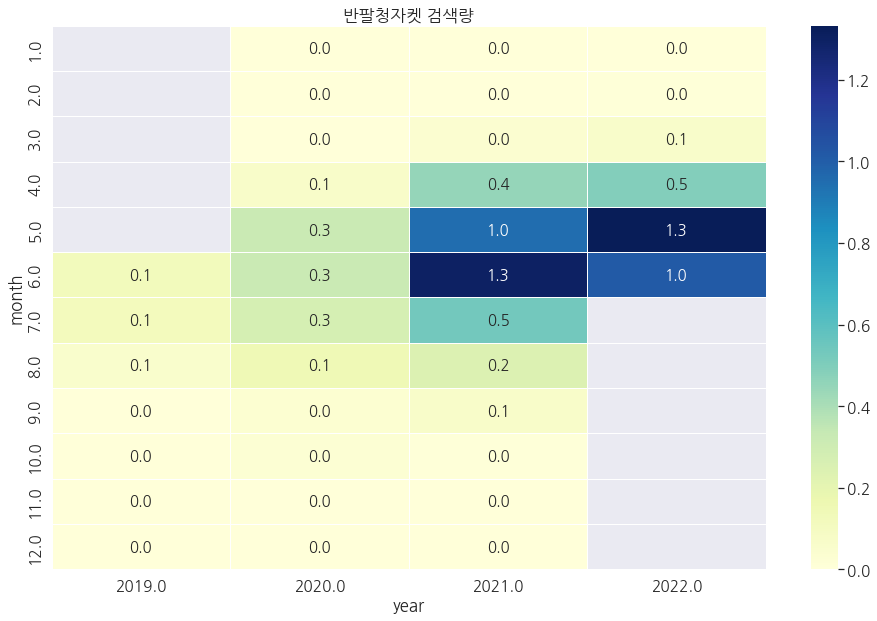

In [72]:
heatplot()

In [332]:
# heatplot_compare() ; 키워드 비교 열지도 시각화
def heatplot_compare():
    """
    '키워드1' vs '키워드2' 검색량을 비교해서 볼 수 있는 시계열 열지도 생성 함수입니다.
    """
    
    print("### 조회 가능한 키워드 정보 ###")
    print("=" * 50)
    print(df_m[['등장일자','키워드']])

    # keyword1, keyword2 = 조회할 키워드 입력
    keyword1 = input("검색량을 조회할 키워드1 입력 :")
    keyword2 = input("검색량을 조회할 키워드2 입력 :")
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10))
    sns.heatmap(df_ym.pivot("month", "year", keyword1), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax1)
    sns.heatmap(df_ym.pivot("month", "year", keyword2), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax2)
    ax1.set_title(keyword1 + " 검색량")
    ax2.set_title(keyword2 + " 검색량")
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword1 + 'vs' + keyword2 + '_히트맵차트.png', bbox_inches='tight')

### 조회 가능한 키워드 정보 ###
          등장일자        키워드
0   2022-05-12        교련복
1   2022-05-12  마르조썸머인견팬츠
2   2022-05-12     반팔크롭자켓
3   2022-05-12      세루티자켓
4   2022-05-13  올리비아로렌티셔츠
..         ...        ...
60  2022-06-10   신영와코루슬림업
61  2022-06-10        아우터
62  2022-06-10   비비안컴포트브라
63  2022-06-11     드로우즈팬티
64  2022-06-11        쎄르페

[65 rows x 2 columns]
검색량을 조회할 키워드1 입력 :한지민가디건
검색량을 조회할 키워드2 입력 :트위드반팔


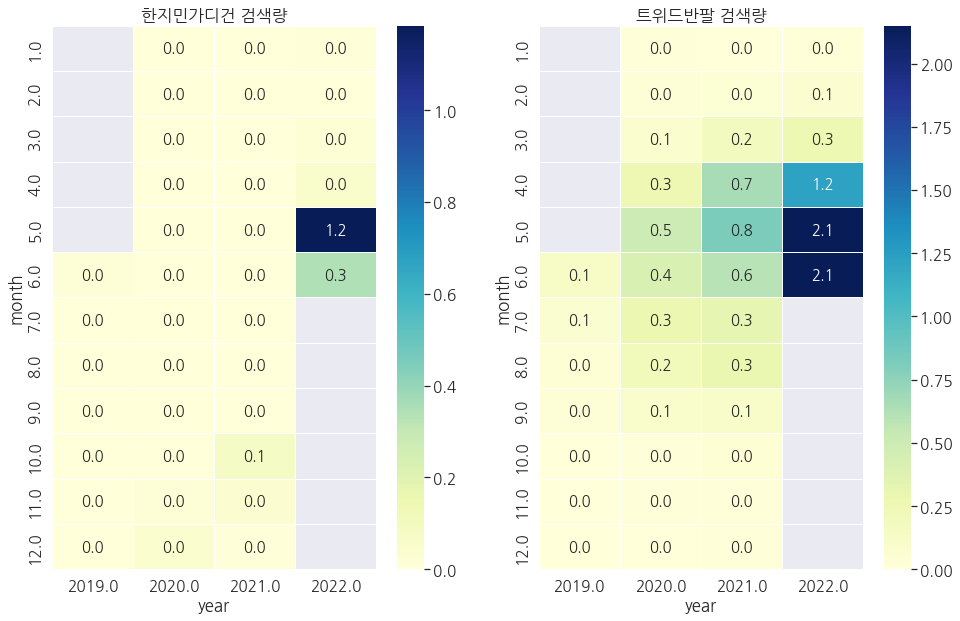

In [337]:
heatplot_compare()

# 키워드 네트워크 시각화용 자료 수집

In [73]:
# df_m = pd.read_csv('C:/project/CODE/keyword/data/fashion/output/' + yesterday + '_trendy_fashion_keywords.csv', encoding='UTF-8', index_col=0)
# lis = list(df_m['키워드'])
lis

['올리비아로렌티셔츠',
 '비비안마이핏네모팬티',
 '안나수이원피스',
 '항균여자사각팬티',
 '나이스',
 '행텐10320-150-404-51',
 '리린',
 '법복',
 '모르간썸머원피스',
 '한지민가디건',
 '스프리스기능성바람막이',
 '쿨스판골지여자밴딩와이드바지',
 '에바큐브',
 '여성정장하객룩',
 '나이키더블스우시후드집업',
 '마틴발썸머울카라니트',
 '여성여름정장',
 '유니클로마르니',
 '딜레탕티즘',
 '셀린느티셔츠',
 '닉스조거팬츠',
 '클로앤차이가디건형니트',
 '디키즈874여자',
 '반팔청자켓',
 '레이지카키하프조거팬츠',
 '테이퍼드세미와이드청바지',
 '남성린넨체크셔츠',
 '트위드반팔',
 '남자무지트임브이넥',
 '마드제이',
 '테이핑브라',
 '데일리셔링청롱원피스',
 '여성반팔가디건',
 '유에르',
 '지오다노101221',
 '커클랜드티셔츠',
 '헬스오버핏반팔티셔츠',
 '테니스원피스',
 '노가다망사작업조끼',
 '텐셀배기진',
 '러브이즈트루',
 '가니송',
 '신혼부부',
 '리스트바지',
 '여성롱원피스',
 '폴로반팔셔츠',
 '리바이스쿨진여성',
 '엉뽕',
 '쿨스판스판팬츠',
 '비비안컴포트브라팬티',
 '맥스튜어트뉴욕데님',
 '질염예방여성면팬티',
 '트임밴딩롱스커트',
 '마리나요팅티셔츠',
 '바스락스커트',
 '달고나라인린넨원피스',
 '비뮤즈맨션',
 '김나영실리콘니플패치니플패드',
 '다다있어민소매',
 '리더잭텐셀풀스트링팬츠',
 '올앤선드리원피스',
 '자바나스반팔',
 '골지니트여성니트',
 '세루티니트',
 '안지크원피스',
 '올리브그린썸머하이웨이팬츠',
 '남자머슬핏반팔무지티셔츠',
 '코닥반팔티',
 '누모브라렛',
 '쌍방울하나만',
 '남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠',
 '컬럼비아유니버시티',
 '어랏오브풀업드로즈80수모달',
 '빅로고헬스티',
 '페미닌럭비티셔츠',
 '굿라이프웍스_아울렛',
 '레이어드트임반팔티',
 '무지여름반

In [74]:
# 

In [75]:
def related_word_parse(word_list, n): 
    """
    검색어의 연관검색어를 반복해서 검색하는 함수입니다.
    ...
    word_list = 검색할 키워드 값이 있는 리스트
    n = 검색어의 연관검색어를 거듭진행할 회차 수 (일단은 3번 위주로)
    """
    if n==0:
        print('작업 종료')
        
    else:
        merge_df = pd.DataFrame()
        for i in tqdm(range(len(word_list))):
            temp_df = pd.DataFrame()
            temp_list = []
            url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=1&ie=utf8&query=' + word_list[i]
            r = requests.get(url)
            soup_r = bs4.BeautifulSoup(r.text, 'lxml')
            print(word_list[i])
            result = soup_r.select('ul.lst_related_srch > li.item')
            time.sleep(1)
            
            
            try:
                result = soup_r.select('ul.lst_related_srch > li.item')
            
            
            # 연관검색어가 없는 키워드일 때 예외처리
            except:
                if pd.isna(result):
                    result = []
                
                    
            if len(result) == 0:
                pass
            
            else:
                for k in result:
                    temp_list.append(k.text.replace("  ",""))
                
                temp_df['sub_word'] = temp_list
                temp_df['sup_word'] = word_list[i]
                temp_df = pd.DataFrame(temp_df, columns=['sup_word', 'sub_word'])
                
                merge_df = pd.concat([merge_df, temp_df], axis=0)
                
        # 반복회차 결과 저장
        dictionary[n] = merge_df

        # 반복호출
        pass_word_list = merge_df['sub_word'].values

        print('==========다음 회차 시작')
        related_word_parse(pass_word_list, n-1)


In [76]:
dictionary = {}
len(lis)

90

In [77]:
# len(df_m_list)

60

In [78]:
related_word_parse(lis, 3)

  0%|          | 0/90 [00:00<?, ?it/s]

올리비아로렌티셔츠
비비안마이핏네모팬티
안나수이원피스
항균여자사각팬티
나이스
행텐10320-150-404-51
리린
법복
모르간썸머원피스
한지민가디건
스프리스기능성바람막이
쿨스판골지여자밴딩와이드바지
에바큐브
여성정장하객룩
나이키더블스우시후드집업
마틴발썸머울카라니트
여성여름정장
유니클로마르니
딜레탕티즘
셀린느티셔츠
닉스조거팬츠
클로앤차이가디건형니트
디키즈874여자
반팔청자켓
레이지카키하프조거팬츠
테이퍼드세미와이드청바지
남성린넨체크셔츠
트위드반팔
남자무지트임브이넥
마드제이
테이핑브라
데일리셔링청롱원피스
여성반팔가디건
유에르
지오다노101221
커클랜드티셔츠
헬스오버핏반팔티셔츠
테니스원피스
노가다망사작업조끼
텐셀배기진
러브이즈트루
가니송
신혼부부
리스트바지
여성롱원피스
폴로반팔셔츠
리바이스쿨진여성
엉뽕
쿨스판스판팬츠
비비안컴포트브라팬티
맥스튜어트뉴욕데님
질염예방여성면팬티
트임밴딩롱스커트
마리나요팅티셔츠
바스락스커트
달고나라인린넨원피스
비뮤즈맨션
김나영실리콘니플패치니플패드
다다있어민소매
리더잭텐셀풀스트링팬츠
올앤선드리원피스
자바나스반팔
골지니트여성니트
세루티니트
안지크원피스
올리브그린썸머하이웨이팬츠
남자머슬핏반팔무지티셔츠
코닥반팔티
누모브라렛
쌍방울하나만
남자냉장고바지시원한쿨아이스와이드슬랙스남자여름밴딩팬츠
컬럼비아유니버시티
어랏오브풀업드로즈80수모달
빅로고헬스티
페미닌럭비티셔츠
굿라이프웍스_아울렛
레이어드트임반팔티
무지여름반팔
비비안컴포트
벤티브팬츠
신영와코루슬림업
아우터
비비안컴포트브라
드로우즈팬티
멘솔드로즈
남성아이스심리스통풍사계절드로즈
쎄르페
현재는아름다워옷
벤티브아이스조거
리본실크잠옷세트
==========다음 회차 시작


  0%|          | 0/301 [00:00<?, ?it/s]

올리비아로렌 반팔
올리비아로렌 나시
올리비아로렌 하단점
올리비아로렌7부
올리비아로렌 광주진월점
비비안 마이핏 모달 네모팬티
비비안 모달 네모팬티
안나수이자수원피스
하객원피스
잇미샤 원피스
린넨원피스
쉬폰 원피스
시슬리 원피스
지고트 원피스
온앤온 원피스
지컷 원피스
바스락원피스
나이스 학부모서비스
나이스지키미
나이스클랍
나이스 학생서비스
나이스고스트클럽
나이스 신용점수
나이스클랍 원피스
나이스파크
나이스평가정보
나이스신용정보
행텐 와이드
리린 블라우스
냥코 리린
리린원피스
리린쇼핑몰
해피어리린
생활법복
법복바지
법복조끼
법복세트
모르간롱원피스
나이키 스우시 후드집업
나이키 더블스우시
나이키 더블스우시 바람막이
나이키 더블스우시 맨투맨
여성여름정장세트
여름여성정장
여성여름정장바지
여름여성정장세트
여성여름정장조끼
여름여성정장바지
여성여름바지정장
여성여름치마정장
여성여름정장베스트
중년여성여름정장
마르니 유니클로
유니클로 마르니 원피스
유니클로 마르니 자켓
유니클로 마르니 셋업
유니클로 마르니 셔츠
유니클로 마르니 매장
유니클로 마르니 바지
유니클로 마르니 스커트
유니클로 마르니 팬츠
유니클로 마르니 블라우스
셀린느 반팔
셀린느 옷
셀린느 맨투맨
셀린느 후드
셀린느 스트라이프
셀린느 나시
셀린느 마차티
셀린느 크롭
셀린느 마차
셀린느 설키
디키즈 874 여자 사이즈
디키즈 874 여자 32
여자 디키즈 874
디키즈874
디키즈 874 사이즈
디키즈 874 화이트
디키즈 874 30
디키즈 874 28
디키즈 874 남자
디키즈 874 블랙
반팔트위드자켓
린넨반팔자켓
반팔크롭자켓
반팔 숏자켓
얇은 청자켓
데님 청자켓
스판청자켓
7부청자켓
민소매청자켓
청자켓조끼
레이지카키하프조거팬츠4종
반팔트위드자켓
반팔 트위드
반팔 트위드 원피스
트위드 반팔 자켓
반팔 트위드 가디건
트위드 반팔 가디건
반팔트위드자켓 코디
미쏘 트위드 반팔
반팔 트위드 투피스
트위드 반팔 원피스
2way테이핑브라
심리스 브라
노와이어브라
누드브라
인견브라
오프숄더 브라
끈없는 브라
앞후크브라
가슴 작

  0%|          | 0/1748 [00:00<?, ?it/s]

올리비아 로렌
비비안 마이핏
비비안 마이핏 모달 네모팬티
비비안 마이핏 네모팬티
6월하객원피스
하객룩 원피스
하객 롱원피스
77하객원피스
결혼식 하객룩
린넨원피스
쉬폰 원피스
뷔스티에 원피스
데님 원피스
스퀘어넥 원피스
잇미샤 트위드 원피스
잇미샤 레이스 원피스
잇미샤 롱원피스
잇미샤 데님원피스
잇미샤 니트원피스
잇미샤쉬폰원피스
잇미샤검정원피스
잇미샤미니원피스
시슬리 원피스
지고트 원피스
린넨롱원피스
린넨셔츠원피스
린넨나시원피스
린넨체크원피스
린넨 미니원피스
린넨반팔원피스
린넨 끈 원피스
브이넥린넨원피스
하객원피스
쉬폰 원피스
쉬폰 롱원피스
쉬폰미니원피스
쉬폰캉캉원피스
쉬폰나시원피스
쉬폰주름원피스
반팔쉬폰원피스
긴팔쉬폰원피스
쉬폰끈원피스
하객원피스
린넨원피스
시슬리 롱원피스
시슬리 니트원피스
시슬리 데님원피스
시슬리 쉬폰원피스
시슬리 랩원피스
시슬리펀칭원피스
시슬리끈원피스
시슬리린넨원피스
시슬리셔츠원피스
시슬리블랙원피스
지고트 쉬폰원피스
지고트롱원피스
지고트 니트원피스
지고트벨트원피스
지고트 반팔원피스
지고트데님원피스
지고트셔츠원피스
지고트배색원피스
잇미샤 원피스
시슬리 원피스
온앤온 롱원피스
온앤온 데님원피스
온앤온 체크원피스
온앤온 니트원피스
온앤온반팔원피스
온앤온셔츠원피스
잇미샤 원피스
시슬리 원피스
지고트 원피스
지컷 원피스
지컷 데님원피스
지컷 니트원피스
지컷 셔링 원피스
지컷 롱원피스
지컷블랙원피스
지컷 카라원피스
지컷펀칭원피스
지컷셔츠원피스
지컷 체크원피스
지컷 린넨원피스
바스락 롱원피스
바스락반팔원피스
바스락퍼프원피스
바스락셔츠원피스
바스락 나시원피스
바스락배색원피스
하객원피스
린넨원피스
쉬폰 원피스
뷔스티에 원피스
나이스 학생서비스
학부모서비스
나이스대국민서비스
나이스
나이스 성적표
나이스신용지키미
나이스지키미 추정소득
나이스지키미 이름
나이스지키미 신용점수
나이스지키미 탈퇴
나이스지키미 고객센터
나이스
나이스 학부모서비스
나이스 학생서비스
나이스신용정보
나이스클랍 원피스
나이스클랍블라우스
나이스클랍 니트
나이스클랍 자켓
나이스클랍 셔츠
나이스

2022년 신혼부부 특별공급 조건
신혼부부 특별공급 점수
신혼부부 특별공급 추첨
2022년 신혼부부 특별공급
무주택신혼부부 특별공급
신혼부부 특별공급 대출
2022 신혼부부 특별공급
신혼부부 특별공급 자동차
신혼부부 컵선물
개업선물
이사선물
신혼집 선물
결혼식 선물
센스있는선물
커플선물
신혼부부 머그컵
신혼부부 집들이 선물추천
집들이선물
센스있는 집들이선물
집들이 선물 추천
신혼집 집들이 선물
간단한 집들이 선물
신혼부부 집들이 음식
결혼 집들이 선물
신혼부부 버팀목 전세자금대출 연장
신혼부부 버팀목 전세자금대출 한도
신혼부부 버팀목 전세자금대출 서류
청년 버팀목 전세자금대출
버팀목 전세자금대출
버팀목전세자금대출 은행
신혼부부 전세자금대출 금리
2022년 신혼부부 전세대출
디딤돌전세자금대출
전세자금 대출
lh 신혼부부전세임대주택
lh 신혼부부전세임대 후기
lh 신혼부부전세임대 재계약
lh 신혼부부전세임대 신청
lh 신혼부부전세임대2
lh 신혼부부전세임대 서류
lh 청년전세임대주택
lh 전세임대주택
lh 전세임대
lh 신혼부부전세대출
2022년 서울시 신혼부부 전세대출
서울시 신혼부부 전세대출 연장
서울시 신혼부부 전세자금대출
서울시 신혼부부 전세대출 후기
서울시 신혼부부 전세대출 금리
서울신혼부부전세대출
신혼부부전세대출
신혼부부 전세대출 연장
2022년 신혼부부 전세대출 이자
신혼부부 전세대출 후기
2022년 신혼부부 전세대출
2022년 신혼부부 매매대출
신혼부부 버팀목 전세자금대출
서울시 신혼부부 전세대출
2022년 신혼부부 디딤돌대출
2022년 신혼부부 대출
2022년 서울시 신혼부부 전세대출
서울신혼부부전세대출
신혼부부 매매대출
신혼부부전세대출
예비신혼부부 청약
신혼부부 청약 조건
주택청약 신혼부부
신혼부부 주택청약
신혼부부 청약 소득
청약 신혼부부
예비신혼부부 청약 조건
2022년 신혼부부 청약
신혼부부 청약 점수
서울 신혼부부 청약
쉬즈미스린넨바지
쉬즈미스면바지
리스트 바지
베네통 바지
올리비아로렌바지
조이너스바지
안지크 바지
나이스클랍 바지
잇미샤 

In [79]:
# 파싱 결과 병합 작업

In [80]:
dictionary[3]

,sup_word,sub_word
0,올리비아로렌티셔츠,올리비아로렌 반팔
1,올리비아로렌티셔츠,올리비아로렌 나시
2,올리비아로렌티셔츠,올리비아로렌 하단점
3,올리비아로렌티셔츠,올리비아로렌7부
4,올리비아로렌티셔츠,올리비아로렌 광주진월점
...,...,...
5,현재는아름다워옷,현재는아름다워
6,현재는아름다워옷,현재는 아름다워 가방
7,현재는아름다워옷,현재는 아름다워 패션
8,현재는아름다워옷,현재는 아름다워 의상


In [81]:
dictionary[2]

,sup_word,sub_word
0,올리비아로렌 반팔,올리비아 로렌
0,비비안 마이핏 모달 네모팬티,비비안 마이핏
0,비비안 모달 네모팬티,비비안 마이핏 모달 네모팬티
1,비비안 모달 네모팬티,비비안 마이핏 네모팬티
0,하객원피스,6월하객원피스
...,...,...
1,현재는 아름다워 의상,현재는 아름다워 미래의상
2,현재는 아름다워 의상,현재는 아름다워 패션
3,현재는 아름다워 의상,현재는 아름다워 원피스
0,현재는 아름다워 원피스,현재는 아름다워 옷


In [82]:
dictionary[1]

,sup_word,sub_word
0,올리비아 로렌,올리비아로렌 원피스
1,올리비아 로렌,올리비아로렌 셔츠
2,올리비아 로렌,올리비아로렌 점퍼
3,올리비아 로렌,올리비아로렌 블라우스
4,올리비아 로렌,올리비아로렌 반팔
...,...,...
0,현재는 아름다워 패션,현재는 아름다워 19회 패션
1,현재는 아름다워 패션,현재는 아름다워 옷
2,현재는 아름다워 패션,현재는 아름다워 가방
3,현재는 아름다워 패션,현재는 아름다워 의상


In [83]:
merge1 = pd.merge(dictionary[3], dictionary[2], left_on='sub_word', right_on='sup_word')
merge2 = pd.merge(dictionary[2], dictionary[1], left_on='sub_word', right_on='sup_word')
merge2

,sup_word_x,sub_word_x,sup_word_y,sub_word_y
0,올리비아로렌 반팔,올리비아 로렌,올리비아 로렌,올리비아로렌 원피스
1,올리비아로렌 반팔,올리비아 로렌,올리비아 로렌,올리비아로렌 셔츠
2,올리비아로렌 반팔,올리비아 로렌,올리비아 로렌,올리비아로렌 점퍼
3,올리비아로렌 반팔,올리비아 로렌,올리비아 로렌,올리비아로렌 블라우스
4,올리비아로렌 반팔,올리비아 로렌,올리비아 로렌,올리비아로렌 반팔
...,...,...,...,...
41082,현재는 아름다워 원피스,현재는 아름다워 패션,현재는 아름다워 패션,현재는 아름다워 가방
41083,현재는 아름다워 원피스,현재는 아름다워 패션,현재는 아름다워 패션,현재는 아름다워 의상
41084,현재는 아름다워 원피스,현재는 아름다워 패션,현재는 아름다워 패션,현재는 아름다워 미래 가방
41085,현재는 아름다워 의상,현재는 아름다워 원피스,현재는 아름다워 원피스,현재는 아름다워 옷


In [84]:
merge1 = merge1.drop(['sub_word_x'], axis=1)
merge1.columns = ['sup_word', 'sub_word1','sub_word2']
merge1

,sup_word,sub_word1,sub_word2
0,올리비아로렌티셔츠,올리비아로렌 반팔,올리비아 로렌
1,비비안마이핏네모팬티,비비안 마이핏 모달 네모팬티,비비안 마이핏
2,비비안마이핏네모팬티,비비안 모달 네모팬티,비비안 마이핏 모달 네모팬티
3,비비안마이핏네모팬티,비비안 모달 네모팬티,비비안 마이핏 네모팬티
4,안나수이원피스,하객원피스,6월하객원피스
...,...,...,...
2031,현재는아름다워옷,현재는 아름다워 의상,현재는 아름다워 미래의상
2032,현재는아름다워옷,현재는 아름다워 의상,현재는 아름다워 패션
2033,현재는아름다워옷,현재는 아름다워 의상,현재는 아름다워 원피스
2034,현재는아름다워옷,현재는 아름다워 원피스,현재는 아름다워 옷


In [85]:
merge2 = merge2.drop(['sup_word_x', 'sub_word_x'], axis=1)
merge2.columns = ['drop', 'sub_word3']
merge2

,drop,sub_word3
0,올리비아 로렌,올리비아로렌 원피스
1,올리비아 로렌,올리비아로렌 셔츠
2,올리비아 로렌,올리비아로렌 점퍼
3,올리비아 로렌,올리비아로렌 블라우스
4,올리비아 로렌,올리비아로렌 반팔
...,...,...
41082,현재는 아름다워 패션,현재는 아름다워 가방
41083,현재는 아름다워 패션,현재는 아름다워 의상
41084,현재는 아름다워 패션,현재는 아름다워 미래 가방
41085,현재는 아름다워 원피스,현재는 아름다워 옷


In [87]:
# 작업결과 저장
total_words = pd.merge(merge1, merge2, left_on='sub_word2', right_on='drop')
total_words = total_words.drop(['drop'], axis=1)
total_words.to_csv('C:/project/CODE/keyword/data/fashion/network/' + yesterday + 'multiple_related_word_parse.csv', encoding='utf-8')
total_words

,sup_word,sub_word1,sub_word2,sub_word3
0,올리비아로렌티셔츠,올리비아로렌 반팔,올리비아 로렌,올리비아로렌 원피스
1,올리비아로렌티셔츠,올리비아로렌 반팔,올리비아 로렌,올리비아로렌 셔츠
2,올리비아로렌티셔츠,올리비아로렌 반팔,올리비아 로렌,올리비아로렌 점퍼
3,올리비아로렌티셔츠,올리비아로렌 반팔,올리비아 로렌,올리비아로렌 블라우스
4,올리비아로렌티셔츠,올리비아로렌 반팔,올리비아 로렌,올리비아로렌 반팔
...,...,...,...,...
424114,현재는아름다워옷,현재는 아름다워 원피스,현재는 아름다워 패션,현재는 아름다워 가방
424115,현재는아름다워옷,현재는 아름다워 원피스,현재는 아름다워 패션,현재는 아름다워 의상
424116,현재는아름다워옷,현재는 아름다워 원피스,현재는 아름다워 패션,현재는 아름다워 미래 가방
424117,현재는아름다워옷,현재는 아름다워 의상,현재는 아름다워 원피스,현재는 아름다워 옷


## 여기서부터는 키워드 네트워크 시각화

#### 일단은 키워드 1개만으로 작업

In [92]:
##### 여기서부터는 임시 작업용 df 호출 #####
# total_words = pd.read_csv('C:/project/CODE/keyword/data/fashion/network/multiple_related_word_parse.csv', encoding='utf-8', index_col=0)
uniq_word = total_words.drop_duplicates(['sup_word'], keep='first')
uniq_wordlist = list(uniq_word['sup_word'])
uniq_wordlist

['올리비아로렌티셔츠',
 '비비안마이핏네모팬티',
 '안나수이원피스',
 '테니스원피스',
 '리린',
 '가니송',
 '비뮤즈맨션',
 '러브이즈트루',
 '올앤선드리원피스',
 '안지크원피스',
 '나이스',
 '여성롱원피스',
 '법복',
 '나이키더블스우시후드집업',
 '여성여름정장',
 '유니클로마르니',
 '셀린느티셔츠',
 '디키즈874여자',
 '반팔청자켓',
 '트위드반팔',
 '레이지카키하프조거팬츠',
 '여성반팔가디건',
 '테이핑브라',
 '비비안컴포트브라',
 '신영와코루슬림업',
 '유에르',
 '지오다노101221',
 '커클랜드티셔츠',
 '자바나스반팔',
 '신혼부부',
 '리스트바지',
 '폴로반팔셔츠',
 '리바이스쿨진여성',
 '엉뽕',
 '비비안컴포트브라팬티',
 '비비안컴포트',
 '맥스튜어트뉴욕데님',
 '바스락스커트',
 '세루티니트',
 '올리브그린썸머하이웨이팬츠',
 '코닥반팔티',
 '아우터',
 '쎄르페',
 '현재는아름다워옷']

In [93]:
def create_nx_df():
    """
    키워드 연관도를 조회하기 위해 필터링된 데이터프레임을 만드는 함수입니다.
    ...
    """
    global df_sup
    keyword = input("연관도를 조회할 키워드를 입력하세요: ")
    df_sup = total_words[total_words['sup_word'] == keyword]
    df_sup
    return(df_sup)

In [94]:
# create_nx_df()

In [101]:
## 조회를 원하는 키워드 명을 input 으로 받는 형태가 나을까나 ~?~?
def create_nx():
    """
    트렌드 키워드의 연관검색어들 
    """
    # 라이브러리
    import networkx as nx
    import matplotlib.font_manager as fm ; from matplotlib import rc
    # 폰트 설정
    font_name = fm.FontProperties(fname="c:/Windows/Fonts/HMKMMAG.ttf").get_name()
    
    print("조회가능힌 키워드 목록입니다.")
    print("=" * 50)
    print(uniq_wordlist)
    print("=" * 50)
    
    create_nx_df()

    # 네트워크 생성
    G = nx.Graph()
    
    for sup in list(set(df_sup['sup_word'].values)):
        G.add_node(sup)
        temp_df1 = df_sup[df_sup['sup_word']==sup]
        for sub1 in list(set(temp_df1['sub_word1'].values)):
            G.add_node(sub1)
            G.add_edge(sup,sub1)
            temp_df2 = temp_df1[temp_df1['sub_word1']==sub1]
            for sub2 in list(set(temp_df2['sub_word2'].values)):
                G.add_node(sub2)
                G.add_edge(sub1,sub2)
                temp_df3 = temp_df2[temp_df2['sub_word2']==sub2]
                for sub3 in list(set(temp_df3['sub_word3'].values)):
                    G.add_node(sub3)
                    G.add_edge(sub2,sub3)
                    
    title = list(df_sup['sup_word'])[0]
    color_map = []
    for node in G:
        if node == title:
            color_map.append('red')
        elif node in list(set(df_sup['sub_word1'].values)):
            color_map.append('orange')
        elif node in list(set(df_sup['sub_word2'].values)):
            color_map.append('yellow')
        else:
            color_map.append('violet')
            
    # 그래프 생성
    plt.figure(figsize=(30, 30))
    d = dict(G.degree)
    nx.draw(G,nodelist=d.keys(), node_size=[v * 1000 for v in d.values()], font_family=font_name,font_size=30, node_color = color_map, with_labels = True)
    # 한글 폰트에러 때문에 별도의 폰트 설정이 필요합니다.
    plt.axis('off')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + title + 'networkx_pic.png')
    plt.title(title + '연관어 관계도', fontsize=50)
    plt.show()
        

조회가능힌 키워드 목록입니다.
['올리비아로렌티셔츠', '비비안마이핏네모팬티', '안나수이원피스', '테니스원피스', '리린', '가니송', '비뮤즈맨션', '러브이즈트루', '올앤선드리원피스', '안지크원피스', '나이스', '여성롱원피스', '법복', '나이키더블스우시후드집업', '여성여름정장', '유니클로마르니', '셀린느티셔츠', '디키즈874여자', '반팔청자켓', '트위드반팔', '레이지카키하프조거팬츠', '여성반팔가디건', '테이핑브라', '비비안컴포트브라', '신영와코루슬림업', '유에르', '지오다노101221', '커클랜드티셔츠', '자바나스반팔', '신혼부부', '리스트바지', '폴로반팔셔츠', '리바이스쿨진여성', '엉뽕', '비비안컴포트브라팬티', '비비안컴포트', '맥스튜어트뉴욕데님', '바스락스커트', '세루티니트', '올리브그린썸머하이웨이팬츠', '코닥반팔티', '아우터', '쎄르페', '현재는아름다워옷']
연관도를 조회할 키워드를 입력하세요: 반팔청자켓


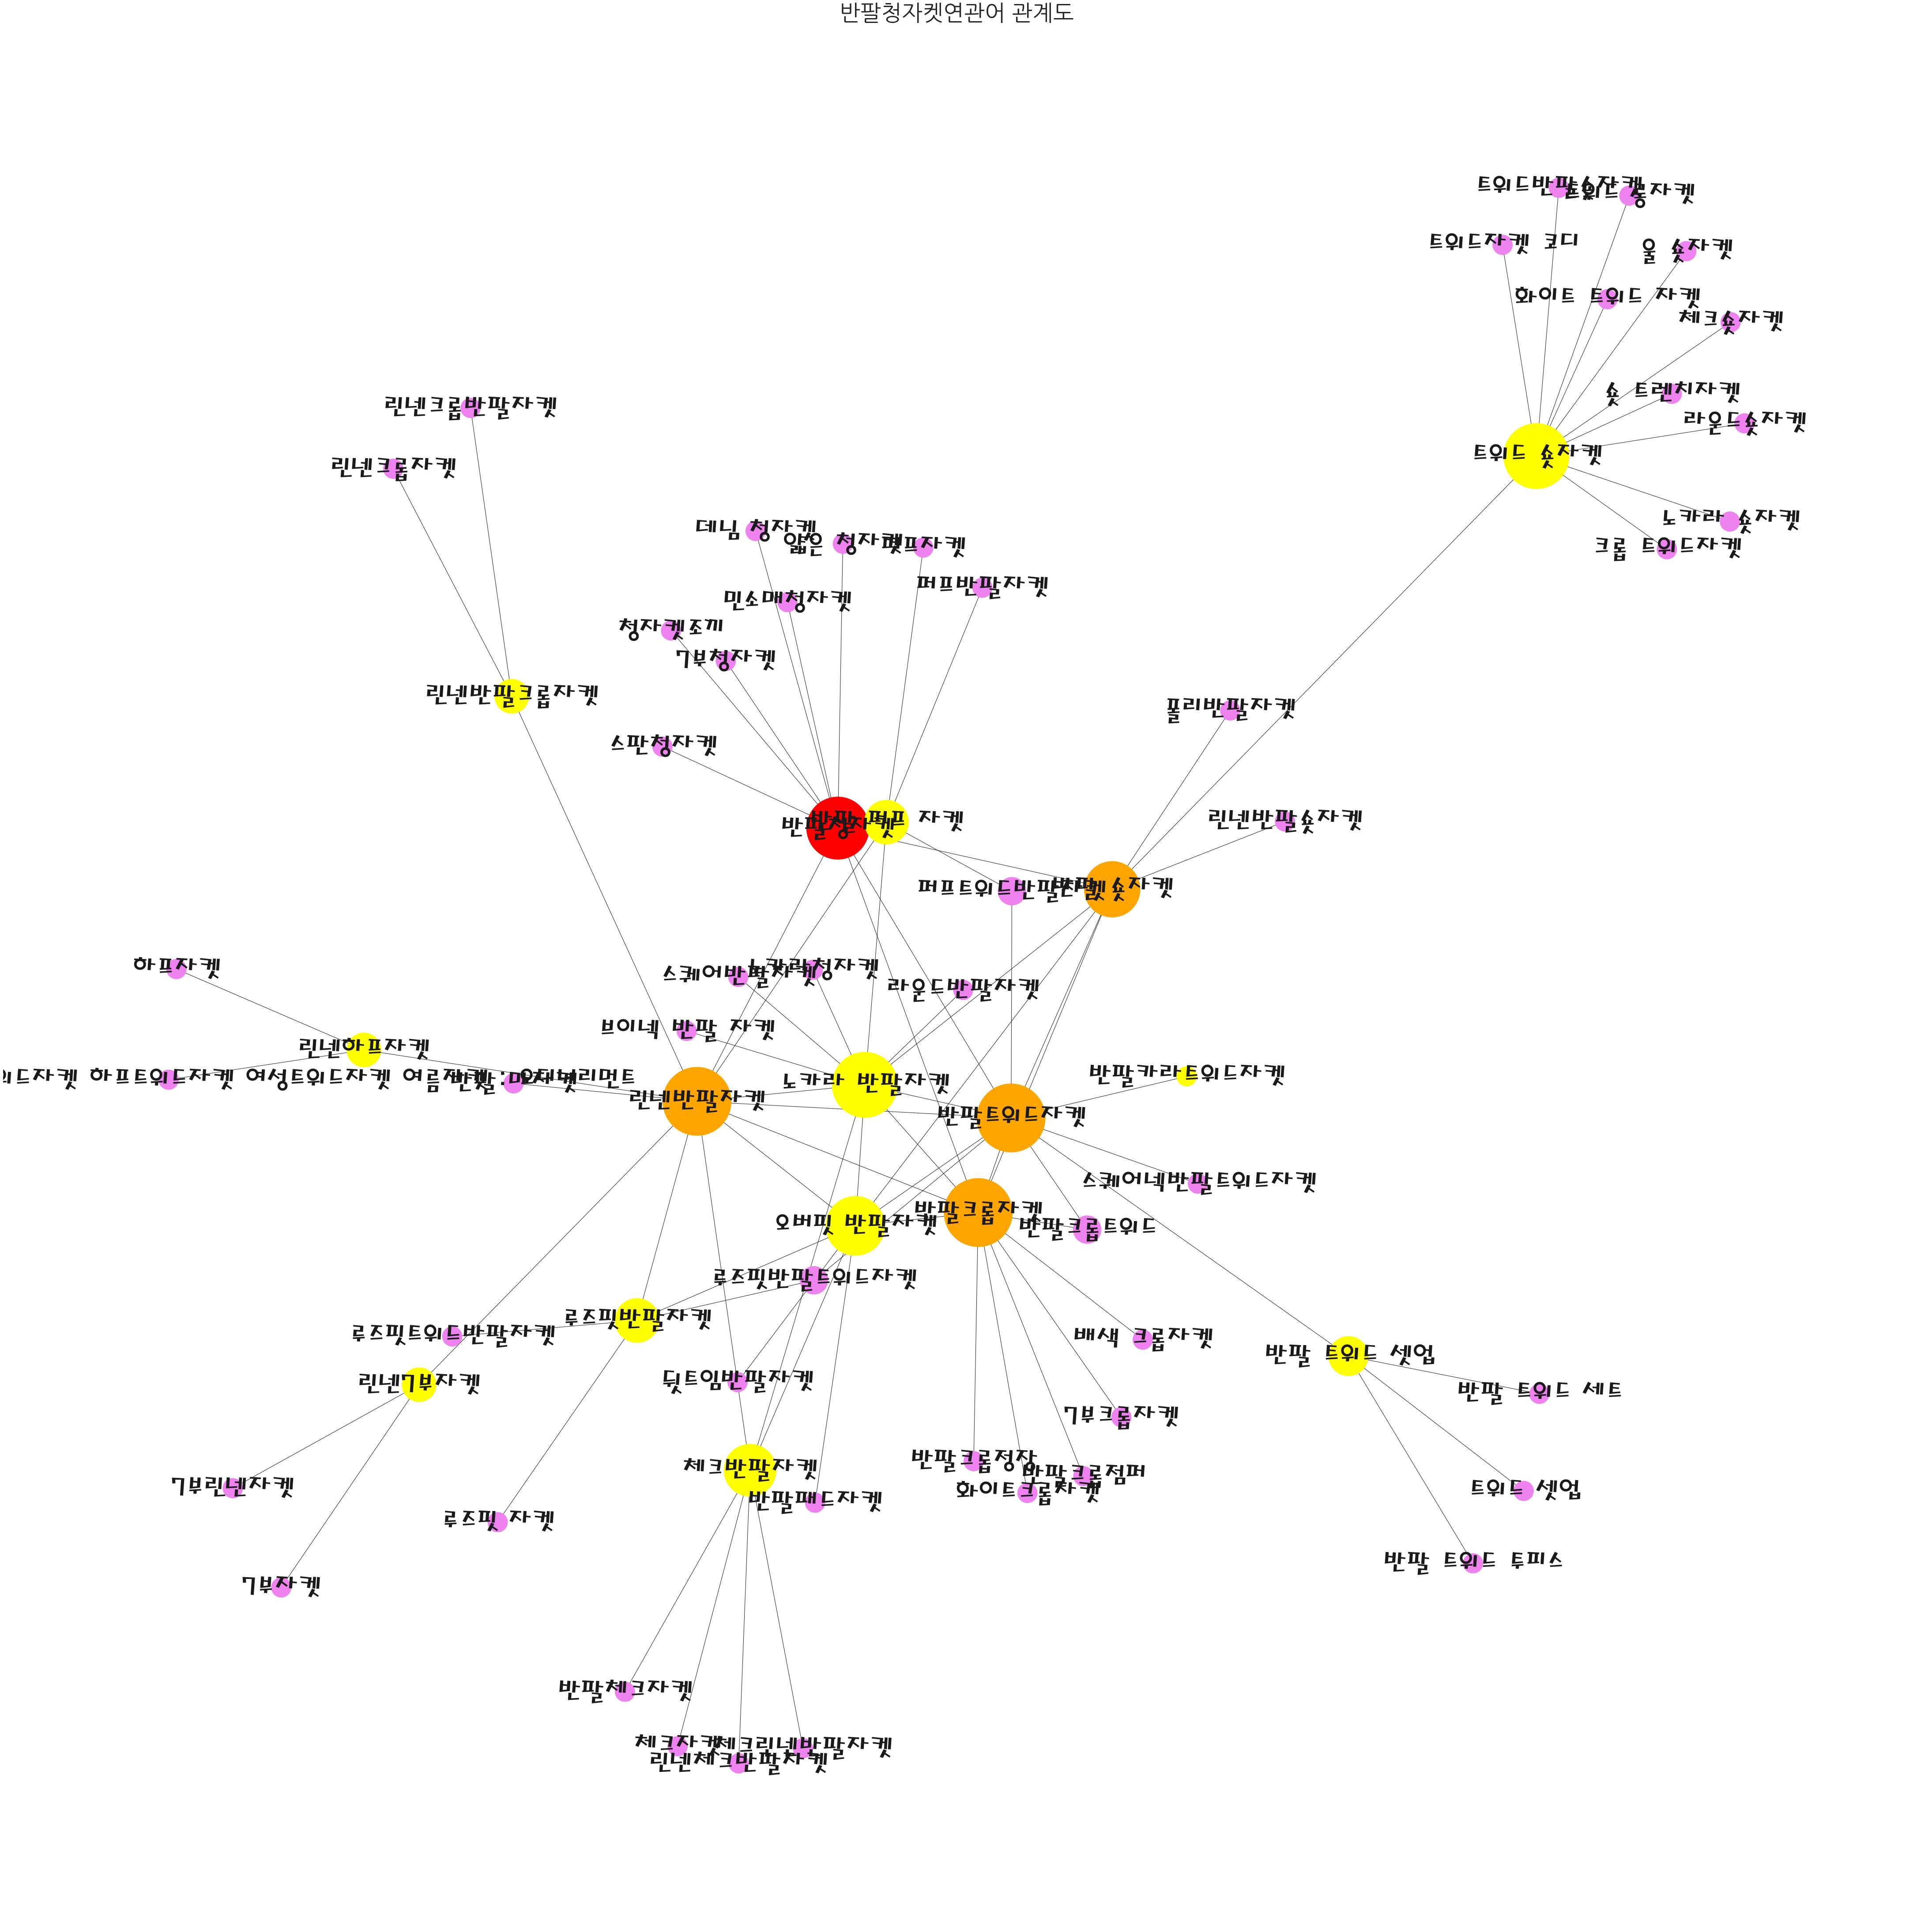

In [105]:
create_nx()

In [168]:
df_ym

잠옷  현재는아름다워옷  쎄르페  드로우즈팬티  비비안컴포트브라  아우터  신영와코루슬림업  컬럼비아유니버시티  \
기간   기간                                                                    
2019 6  16.93      0.00 0.00    0.00      0.00 2.23      0.00       0.00   
     7  18.26      0.00 0.00    0.01      0.00 1.91      0.00       0.00   
     8  18.09      0.00 0.00    0.00      0.00 2.36      0.00       0.00   
     9  22.80      0.00 0.00    0.00      0.00 4.24      0.00       0.00   
     10 30.69      0.00 0.01    0.01      0.00 6.73      0.00       0.00   
     11 33.77      0.00 0.01    0.00      0.00 7.70      0.00       0.00   
     12 38.00      0.00 0.01    0.00      0.00 4.20      0.00       0.00   
2020 1  29.98      0.00 0.01    0.00      0.00 3.83      0.00       0.00   
     2  36.90      0.00 0.00    0.01      0.00 4.73      0.00       0.00   
     3  57.02      0.00 0.00    0.00      0.00 4.90      0.00       0.00   
     4  54.79      0.00 0.01    0.00      0.00 3.77      0.00       0.00   
     5  48.91      0.00 0.02    0.01      0.00 2.17      0.00       0.00   
     6  38.33      0.00 0.02    0.01      0.00 1.34      0.00       0.00   
     7  31.74      0.00 0.03    0.00      0.00 1.32      0.00       0.00   
     8  34.98      0.00 0.03    0.01      0.00 1.71      0.00       0.00   
     9  52.13      0.00 0.09    0.00      0.00 4.00      0.00       0.00   
     10 59.20      0.00 0.04    0.00      0.00 7.74      0.00       0.00   
     11 49.37      0.00 0.03    0.01      0.00 6.98      0.00       0.00   
     12 71.81      0.00 0.02    0.00      0.00 3.65      0.00       0.00   
2021 1  51.79      0.00 0.01    0.01      0.00 3.06      0.00       0.00   
     2  40.50      0.00 0.01    0.02      0.00 3.93      0.00       0.00   
     3  37.53      0.00 0.02    0.17      0.00 5.03      0.00       0.00   
     4  36.04      0.00 0.03    0.46      0.00 3.28      0.00       0.00   
     5  34.28      0.00 0.08    1.72      0.00 2.04      0.00       0.00   
     6  30.51      0.00 0.06    1.26      0.00 1.18      0.00       0.00   
     7  31.56      0.00 0.05    1.35      0.00 1.07      0.00       0.00   
     8  28.40      0.00 0.04    1.12      0.00 2.18      0.00       0.00   
     9  33.71      0.00 0.03    0.01      0.00 3.51      0.00       0.06   
     10 46.02      0.00 0.05    0.00      0.00 6.41      0.00       0.08   
     11 41.98      0.00 0.05    0.00      0.00 6.23      0.00       0.11   
     12 43.47      0.00 0.06    0.00      0.00 3.56      0.00       0.14   
2022 1  34.42      0.00 0.03    0.01      0.00 2.94      0.00       0.25   
     2  36.94      0.00 0.03    0.01      0.00 3.62      0.00       0.19   
     3  34.38      0.00 0.04    0.01      0.00 4.41      0.20       0.18   
     4  33.20      0.49 0.06    0.02      0.00 2.59      0.50       0.17   
     5  28.92      4.36 0.14    0.03      0.11 1.51      0.44       0.24   
     6  28.76      8.80 0.07    0.02      0.27 1.10      0.92       0.12   

         쌍방울하나만  누모브라렛  ...  모르간썸머원피스   법복    리린  행텐10320-150-404-51  안나수이원피스  \
기간   기간                 ...                                                     
2019 6     0.00   0.00  ...      0.00 0.91 66.06                0.00     0.06   
     7     0.00   0.00  ...      0.00 1.01 61.58                0.00     0.05   
     8     0.00   0.00  ...      0.00 0.95 51.14                0.00     0.04   
     9     0.00   0.00  ...      0.00 1.09 59.60                0.00     0.02   
     10    0.00   0.00  ...      0.00 1.10 67.38                0.00     0.02   
     11    0.00   0.00  ...      0.00 0.85 72.03                0.00     0.02   
     12    0.00   0.00  ...      0.00 0.80 62.80                0.00     0.02   
2020 1     0.00   0.00  ...      0.00 0.96 51.55                0.00     0.02   
     2     0.00   0.00  ...      0.00 0.95 59.25                0.00     0.06   
     3     0.00   0.00  ...      0.00 0.72 65.45                0.00     0.08   
     4     0.00   0.00  ...      0.18 0.98 64.44                0.00     0

In [211]:
# heatplot() ; 단일 키워드 열지도 시각화
def heatplot_type2(keyword_name):
    """
    키워드의 검색량을 볼 수 있는 시계열 열지도 생성 함수입니다.
    ...
    keyword = 열지도를 생성하고싶은 키워드
    """
    
    # sns.heatmap
    # df_ym을 조회하려는 키워드의 검색량을 row = 월 / column = 년 으로 pivot 합니다.
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym_instant.pivot("month", "year", keyword_name), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword_name + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword_name + '_히트맵차트.png', bbox_inches='tight')

In [212]:
# datalab_api
def datalab_api_single(keywords):
    """
    네이버 데이터랩 API를 활용해 입력된 키워드의 최근 3년간 일자별 검색량을 조회하는 함수입니다.
    ...
    list_name = 검색량을 조회하고자 하는 키워드
    """
    
    # 데이터랩 API 계정 및 url 정보
    client_id = "kJG1RgASjzoPJ2bpUq8L"    
    client_secret = "LBYXkCdlRf"
    url = "https://openapi.naver.com/v1/datalab/search"
    
    # 조회 조건 설정
    '''
    startdate = 검색량 조회 시작일자
    enddate = 검색량 조회 종료일자
    timeunit = 검색량 수집 기준
    keywordgroups = 조회를 원하는 키워드 그룹
    '''
    body = {
        "startDate":time_three_years,
        "endDate":yesterday,
        "timeUnit":"date",
        "keywordGroups":[
            {"groupName":str(keywords[0]),"keywords":[str(keywords[0])]},
            {"groupName":str(keywords[1]),"keywords":[str(keywords[1])]}
        ],
    }
    
    # 검색량 조회 결과값이 들어있는 딕셔너리 변수
    body = json.dumps(body)
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    json_obj = json.loads(response.read().decode('utf-8'))

    # 조회한 5개의 키워드 검색량을 각각의 데이터프레임에 저장
    df1 = pd.DataFrame(json_obj['results'][0]['data'])
    df2 = pd.DataFrame(json_obj['results'][1]['data'])

    
    
    # 딕셔너리 안에 조회 결과가 들어있지 않아서 데이터프레임을 생성하지 못할 시 오류가 발생하는 경우를 방지하기 위한 반복문
    # 데이터프레임 생성에 실패한 경우 값이 0으로 채워진 데이터프레임을 생성
    df_list = [df1,df2]
    for i in tqdm(range(len(df_list))):
        if len(list(df_list[i].columns)) ==2:
            df_list[i].columns=['기간', str(keywords[i])]
        elif len(list(df_list[i].columns)) ==0:
            df_list[i]['기간'] = 0
            df_list[i][str(keywords[i])] = 0

    # 5개의 키워드 검색량 데이터프레임 병합
    df2 = df1.merge(df2, how='outer', on='기간').fillna(0)

    return df2

In [223]:
# datalab_api_keylist
def datalab_api_instant():
    """
    기준 키워드를 기준으로 최소-최대 정규화를 적용한 데이터랩 검색량을 추출하는 함수입니다.
    검색량을 조회할 단일 키워드 input 값을 받아 실시간으로 검색량을 조회합니다.
    ...
    
    """
    
    keyword_name = input("조회하고 싶은 키워드를 입력하세요: ")
    list_x = [[]]
    list_x = ['잠옷'], [keyword_name]
    # df_api
    # 기준 키워드(잠옷)의 검색량 최소값과 최대값을 구하는 정규화 작업으로 키워드별 실제 검색량의 상대치를 보정합니다.
    df_api = datalab_api_single(list_x[0] + list_x[1])
    df_api = df_api.drop(['잠옷'], axis=1)
    a, b = df_api.iloc[:,1].min(), df_api.iloc[:,1].max()
    
    
    # 저장
    df_api.to_csv('C:/project/CODE/keyword/data/fashion/query/' + yesterday + '_' + keyword_name + '_일자별_검색량.csv', encoding='UTF-8')

    
    
    
    
    # 히트맵 시각화용 데이터 프레임 생성
    df_api['기간']= pd.to_datetime(df_api['기간'])
    df_api['year'] = df_api['기간'].dt.year
    df_api['month'] = df_api['기간'].dt.month
    df_api['date'] = df_api['기간'].dt.date
    df_api = df_api.set_index('기간') # 년월일을 인덱스로 지정





    # df_ym
    # 연도와 월을 인덱스로 지정한 후 키워드 검색량을 연월로 그룹화해서 연월별 평균 검색량을 조회합니다.
    df_api['year'] = df_api.index.year; df_api['month'] = df_vis.index.month
    df_ym_instant = df_api.groupby([df_api.index.year, df_api.index.month]).mean()
    
    
    # 키워드 연월별 평균 검색량 열지도 시각화
    f, ax = plt.subplots(figsize=(16,10))
    sns.heatmap(df_ym_instant.pivot("month", "year", keyword_name), cmap="YlGnBu",
               annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, ax=ax)
    ax.set_title(keyword_name + ' 검색량')
    plt.savefig('C:/project/CODE/keyword/data/fashion/figs/' + yesterday + '_' + keyword_name + '_히트맵차트.png', bbox_inches='tight')
    
    
    # 키워드 연월별 평균 검색량
#     return df_ym_instant


조회하고 싶은 키워드를 입력하세요: 손석구


  0%|          | 0/2 [00:00<?, ?it/s]

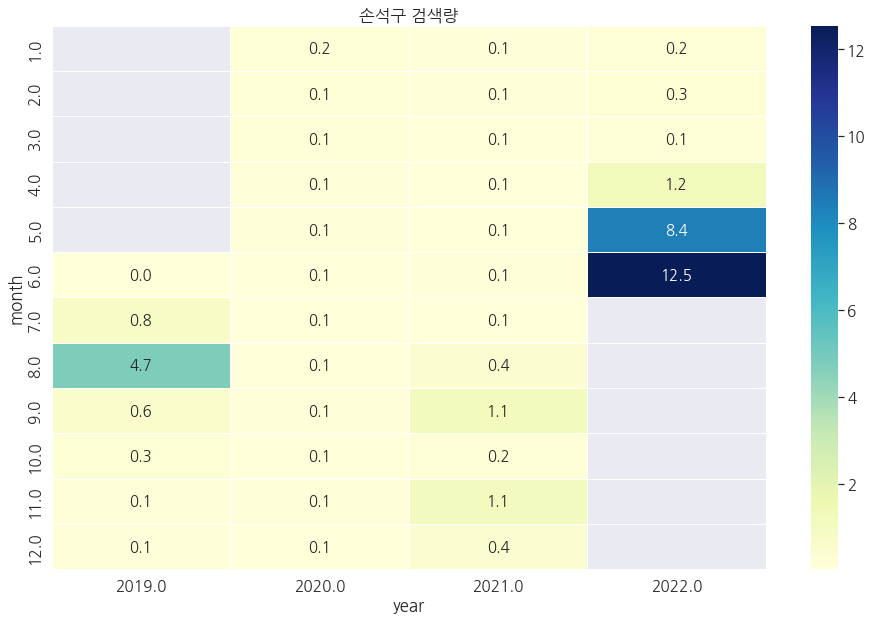

In [224]:
datalab_api_instant()

# 키워드 형태소분석 도전

In [189]:
# 라이브러리
import konlpy
import pickle

from konlpy.tag import Okt
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [190]:
# from konlpy.tag import Okt
# okt 예시
# okt = Okt()
# print(okt.nouns(read_keywords)) # nouns = 명사

NameError: name 'read_keywords' is not defined

In [403]:
# df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/fashion/output/' + yesterday + '_trendy_fashion_keywords.csv', encoding='UTF-8', index_col=0)
df_konlpy = pd.read_csv('C:/project/CODE/keyword/data/fashion/network/2022-06-11_multiple_related_word_parse.csv', encoding='UTF-8', index_col=0)
# write_keywords = list(df_konlpy[0])
# write_keywords

In [453]:
def create_wc_df():
    global df_wc
    """
    특정 키워드와 해당 키워드의 다중 연관검색어들을 워드클라우드로 시각화 하는 함수입니다.
    ...
    """
    print("조회가능힌 키워드 목록입니다.")
    print("=" * 50)
    print(uniq_wordlist)
    print("=" * 50)
    
    keyword = input("워드 클라우드를 조회할 키워드를 입력하세요: ")
    
    
    # 워드클라우드를 조회하기 위해 특정 키워드로 필터링된 데이터프레임 생성
    df_sup = df_konlpy[df_konlpy['sup_word'] == keyword]
    sup_word = list(df_konlpy.iloc[:,0])
    sub_word1 = list(df_konlpy.iloc[:,1])
    sub_word2 = list(df_konlpy.iloc[:,2])
    sub_word3 = list(df_konlpy.iloc[:,3])
    df_wc = sup_word + sub_word1 + sub_word2 + sub_word3
    
    return(df_wc)

In [454]:
create_wc_df()
    
#제목 및 본문 txt에 저장
text = open('trash.txt','w',encoding='UTF-8')
for i in df_wc:
    text.write(i)
    text.write(" ") # 띄어쓰기 구분
text.close()

# text 파일 읽어오기
text = open('trash.txt','rt', encoding='UTF-8').read()
# print("블로그 텍스트 내용: " + blog_text)

# Okt 함수를 이용해 형태소 분석
okt = Okt()
line =[]

line = okt.pos(text)

n_adj =[]
# 명사 또는 형용사인 단어만 n_adj에 넣어주기
for word, tag in tqdm(line):
    if tag in ['Noun']:
        n_adj.append(word)

# print(n_adj)

# 불용어 사전
f = open("C:/project/CODE/keyword/data/stopwords/stopwords_korean.txt", "rt", encoding="utf-8")
lines = f.readlines()
stop_words = []
for line in tqdm(lines):
    line = line.replace('\n', '') #txt 읽을 때 \n 제거
    stop_words.append(line)
f.close()
# stop_words

n_adj = [word for word in tqdm(n_adj) if not word in stop_words]

# print(line)
# print(n_adj)

remove_one_word = [x for x in tqdm(n_adj) if len(x)>1 or x=='핏' or x=='청' or x=='롱' or x=='티']


#가장 많이 나온 단어 n개 저장
counts = Counter(n_adj)
tags = counts.most_common(50) # 저장 개수 지정



# 이미지 추가(워드 클라우드 모양 설정)

mask = Image.new("RGBA",(1500,1500), (255,255,255)) #(2500,2500) = 이미지 크기, (255,255,255) = RGB
image = Image.open('C:/project/img/square.png').convert("RGBA")
x,y = image.size
mask.paste(image,(0,0,x,y),image)
mask = np.array(mask)

### 워드 클라우드 생성 ###
#폰트지정
# sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
font='C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/MALGUN.ttf'
word_cloud = WordCloud(font_path=font, background_color='black',max_font_size=400, mask=mask,colormap='prism').generate_from_frequencies(dict(tags))


# 사이즈 설정 및 화면에 출력
plt.figure(figsize=(24,24))
plt.imshow(word_cloud)
plt.axis('off')
#워드클라우드 사진으로 저장
#cloud.to_file('네이버_키워드_블로그_워드클라우드.png')
#또는
plt.savefig('C:/project/CODE/keyword/data/fashion/wordcloud/' + yesterday + 'wordcloud.png', bbox_inches='tight')
plt.show()



조회가능힌 키워드 목록입니다.
['교련복', '마르조썸머인견팬츠', '반팔크롭자켓', '반팔청자켓', '트위드반팔', '세루티자켓', '올리비아로렌티셔츠', '비비안마이핏네모팬티', '안나수이원피스', '테니스원피스', '리린', '가니송', '비뮤즈맨션', '러브이즈트루', '올앤선드리원피스', '안지크원피스', '나이스', '여성롱원피스', '법복', '나이키더블스우시후드집업', '여성여름정장', '유니클로마르니', '셀린느티셔츠', '디키즈874여자', '레이지카키하프조거팬츠', '여성반팔가디건', '테이핑브라', '신영와코루슬림업', '비비안컴포트브라', '유에르', '지오다노101221', '커클랜드티셔츠', '자바나스반팔', '신혼부부', '리스트바지', '폴로반팔셔츠', '리바이스쿨진여성', '엉뽕', '비비안컴포트브라팬티', '비비안컴포트', '맥스튜어트뉴욕데님', '바스락스커트', '세루티니트', '올리브그린썸머하이웨이팬츠', '코닥반팔티', '아우터']
워드 클라우드를 조회할 키워드를 입력하세요: 반팔크롭자켓


KeyboardInterrupt: 

In [428]:
# 데이터프레임 생성
create_wc_df()

#제목 및 본문 txt에 저장
text = open('trash.txt','w',encoding='UTF-8')
for i in to_wordcloud:
    text.write(i)
    text.write(" ") # 띄어쓰기 구분
text.close()

# text 파일 읽어오기
text = open('trash.txt','rt', encoding='UTF-8').read()
# print("블로그 텍스트 내용: " + blog_text)

# Okt 함수를 이용해 형태소 분석
okt = Okt()
line =[]

line = okt.pos(text)

n_adj =[]
# 명사 또는 형용사인 단어만 n_adj에 넣어주기
for word, tag in line:
    if tag in ['Noun']:
        n_adj.append(word)

# print(n_adj)

# 불용어 사전
f = open("C:/project/CODE/keyword/data/stopwords/stopwords_korean.txt", "rt", encoding="utf-8")
lines = f.readlines()
stop_words = []
for line in lines:
    line = line.replace('\n', '') #txt 읽을 때 \n 제거
    stop_words.append(line)
f.close()
# stop_words

n_adj = [word for word in n_adj if not word in stop_words]

# print(line)
# print(n_adj)

remove_one_word = [x for x in n_adj if len(x)>1 or x=='핏' or x=='청' or x=='롱' or x=='티']


#가장 많이 나온 단어 n개 저장
counts = Counter(n_adj)
tags = counts.most_common(50) # 저장 개수 지정



# 이미지 추가(워드 클라우드 모양 설정)

mask = Image.new("RGBA",(1500,1500), (255,255,255)) #(2500,2500) = 이미지 크기, (255,255,255) = RGB
image = Image.open('C:/project/img/square.png').convert("RGBA")
x,y = image.size
mask.paste(image,(0,0,x,y),image)
mask = np.array(mask)

### 워드 클라우드 생성 ###
#폰트지정
# sns.set(style='darkgrid', font='NanumGothic', font_scale=1.2)
font='C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/MALGUN.ttf'
word_cloud = WordCloud(font_path=font, background_color='black',max_font_size=400, mask=mask,colormap='prism').generate_from_frequencies(dict(tags))


# 사이즈 설정 및 화면에 출력
plt.figure(figsize=(24,24))
plt.imshow(word_cloud)
plt.axis('off')
#워드클라우드 사진으로 저장
#cloud.to_file('네이버_키워드_블로그_워드클라우드.png')
#또는
plt.savefig('C:/project/CODE/keyword/data/fashion/wordcloud/' + yesterday + 'wordcloud.png', bbox_inches='tight')
plt.show()



조회가능힌 키워드 목록입니다.
['교련복', '마르조썸머인견팬츠', '반팔크롭자켓', '반팔청자켓', '트위드반팔', '세루티자켓', '올리비아로렌티셔츠', '비비안마이핏네모팬티', '안나수이원피스', '테니스원피스', '리린', '가니송', '비뮤즈맨션', '러브이즈트루', '올앤선드리원피스', '안지크원피스', '나이스', '여성롱원피스', '법복', '나이키더블스우시후드집업', '여성여름정장', '유니클로마르니', '셀린느티셔츠', '디키즈874여자', '레이지카키하프조거팬츠', '여성반팔가디건', '테이핑브라', '신영와코루슬림업', '비비안컴포트브라', '유에르', '지오다노101221', '커클랜드티셔츠', '자바나스반팔', '신혼부부', '리스트바지', '폴로반팔셔츠', '리바이스쿨진여성', '엉뽕', '비비안컴포트브라팬티', '비비안컴포트', '맥스튜어트뉴욕데님', '바스락스커트', '세루티니트', '올리브그린썸머하이웨이팬츠', '코닥반팔티', '아우터']
워드 클라우드를 조회할 키워드를 입력하세요: 교련복


ValueError: We need at least 1 word to plot a word cloud, got 0.

한글자 처리 전 단어 총 개수:165
한글자 처리 후 단어 총 개수:142


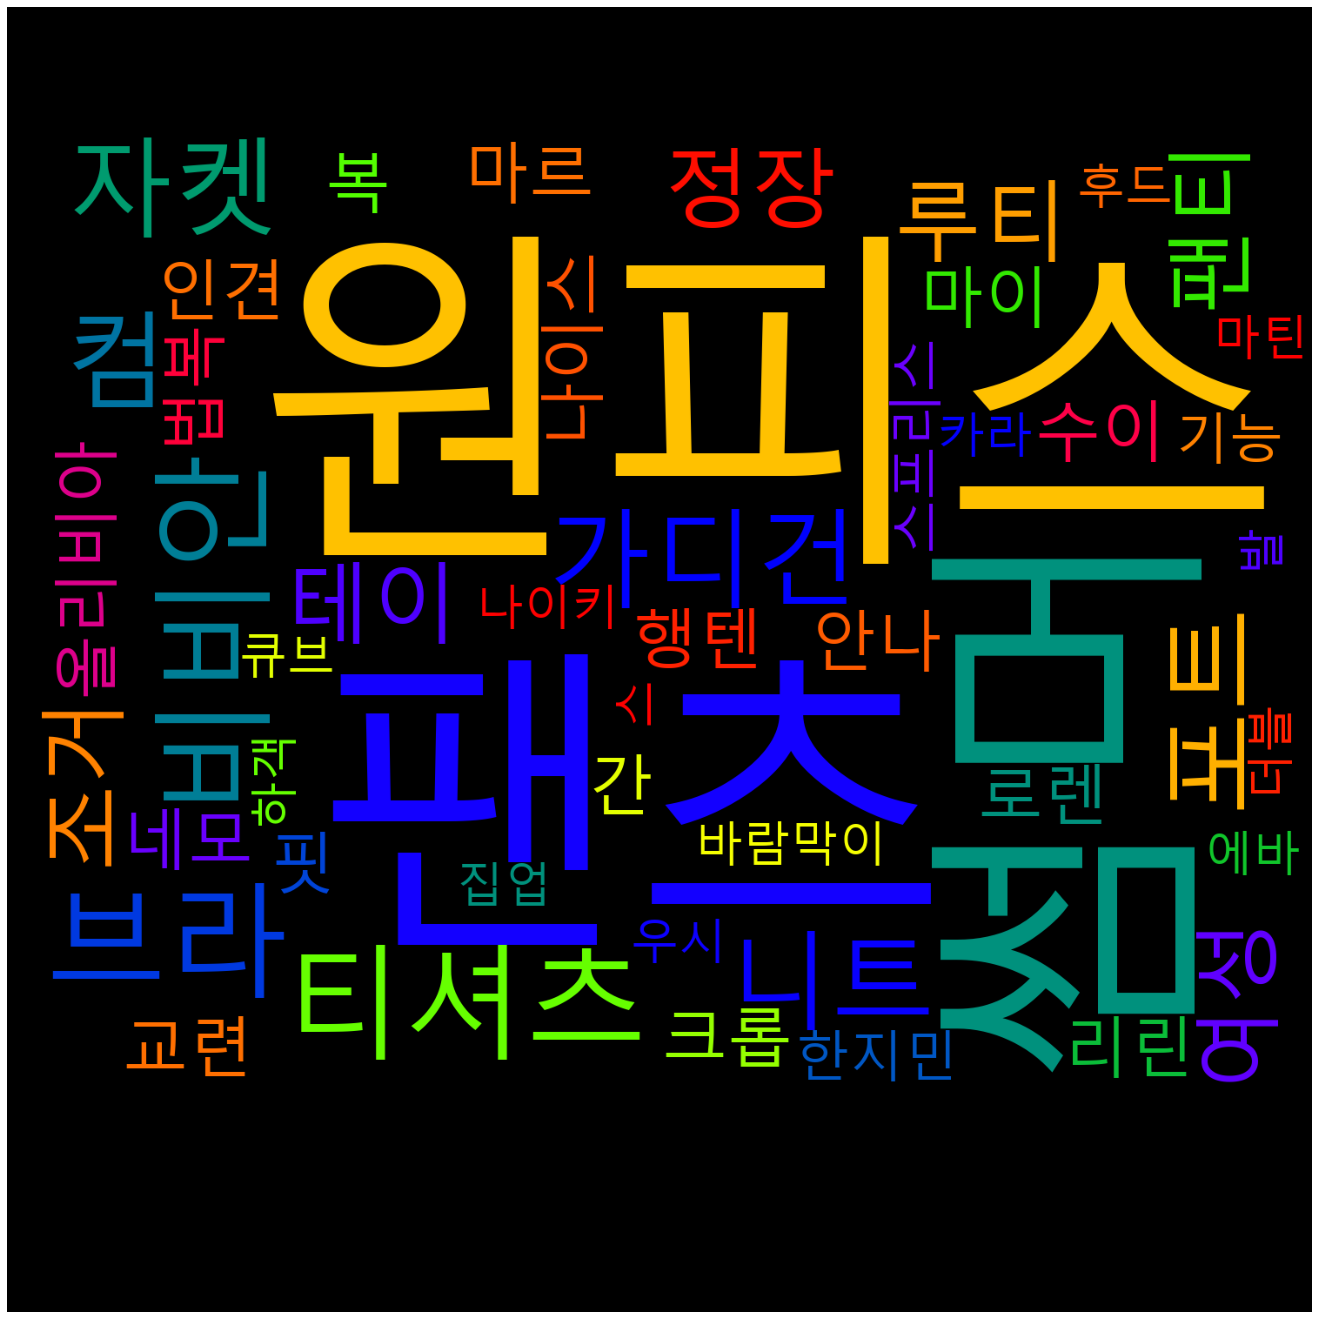

In [198]:
# 자동 띄어쓰기 모듈
from pykospacing import Spacing

In [199]:
spacing = Spacing()

In [200]:
for item in write_keywords:
    kospacing_item = spacing(item)
    print(kospacing_item)

1/1 [==============================] - 1s 537ms/step
교련복
1/1 [==============================] - 0s 24ms/step
마르조 썸머 인 견 팬츠
1/1 [==============================] - 0s 23ms/step
반팔크롭자켓
1/1 [==============================] - 0s 25ms/step
세루티 자켓
1/1 [==============================] - 0s 26ms/step
올리비아로 렌티셔츠
1/1 [==============================] - 0s 27ms/step
비비안 마이핏 네모 팬티
1/1 [==============================] - 0s 23ms/step
안나수 이 원피스
1/1 [==============================] - 0s 23ms/step
나이스
1/1 [==============================] - 0s 26ms/step
행텐 10320-150-404-51
1/1 [==============================] - 0s 22ms/step
리린
1/1 [==============================] - 0s 23ms/step
법복
1/1 [==============================] - 0s 27ms/step
모르간 썸머 원피스
1/1 [==============================] - 0s 26ms/step
한지민 가디건
1/1 [==============================] - 0s 23ms/step
스프리스 기능성 바람막이
1/1 [==============================] - 0s 23ms/step
에바큐브
1/1 [==============================] - 0s 32ms/step
여성 정장 하객룩
1/1 [=================

# 트리박스 시각화...출하??

In [103]:
# shapes
"""
1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드들의 최근 1개월간 평균 검색량을 추출한 데이터프레임입니다.
"""
shapes = df_vis.copy()
shapes = shapes.truncate(before=time_month)
shapes = shapes.mean()
shapes = shapes.reset_index()
shapes.columns = ['keyword', 'month_avg_query']
shapes = shapes[:-2]
shapes = shapes.sort_values('month_avg_query', ascending=False).reset_index(drop=True)
shapes.head(20)

C:\Users\User\AppData\Local\Temp\ipykernel_20456\3092077136.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  shapes = shapes.mean()


,keyword,month_avg_query
0,리린,28.500079
1,김건희옷,15.449799
2,나이스,13.570576
3,운동화,13.052885
4,유니클로마르니,8.887810
5,마드제이,2.224100
6,디키즈874여자,1.889672
7,교련복,1.583467
8,폴로반팔셔츠,1.495555
9,셀린느티셔츠,1.452009


<AxesSubplot:title={'center':'최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드'}>

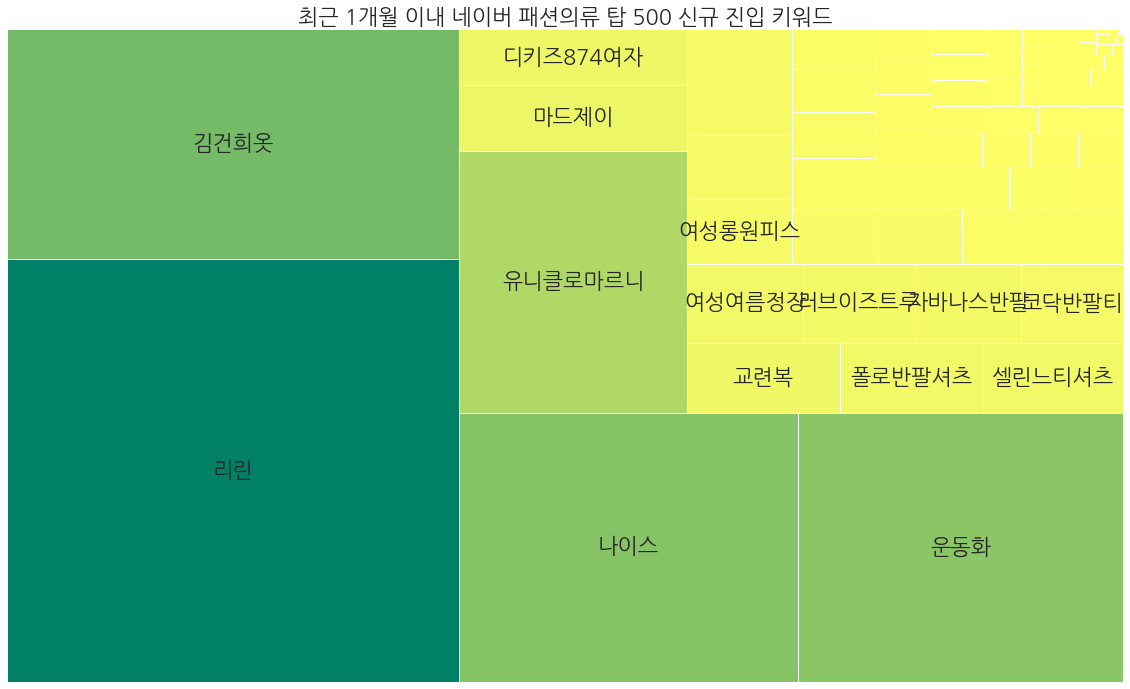

In [107]:
# 색상지도 시각화
cmap = matplotlib.cm.summer_r
norm = matplotlib.colors.Normalize(vmin=shapes.month_avg_query.min(), vmax=shapes.month_avg_query.max())
colors = [cmap(norm(value)) for value in shapes.month_avg_query]

# 연도별 블로그, 카페 건수 트리맵
plt.figure(figsize=(20,12)); plt.axis('off') ; plt.title("최근 1개월 이내 네이버 패션의류 탑 500 신규 진입 키워드")
squarify.plot(
    sizes=shapes.month_avg_query,
    color=colors,
    label=shapes.apply(lambda x: str(x.keyword) if x.month_avg_query >= 1 else '', axis=1),
    alpha=1)
